### TITLE HERE

In [510]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import metrics
from scipy.stats import ks_2samp
from scipy.stats import t
plt.style.use('ggplot')

<style>
  table {
      width: 100%;
      border-collapse: collapse;
      font-family: Arial, sans-serif;
      font-size: 1.1em;
  }
  th, td {
      text-align: left;
      padding: 12px;
  }
  th {
      background-color: #15616d;
      color: white;
  }
  tr:nth-child(odd) {
      background-color: #ffecd1;
  }
  tr:nth-child(even) {
      background-color: #f2f2f2;
  }
  tr:hover {
      background-color: #ff7d00;
      color: white;
  }
</style>

<table>
    <tr><th>Variable Name</th><th>Possible Values and Explanation</th></tr>
    <tr><td><strong>reference_date</strong></td><td>Dates representing the reference period for the data.</td></tr>
    <tr><td><strong>index</strong></td><td>A unique identifier for each record.</td></tr>
    <tr><td><strong>gender</strong></td><td>M: Male, F: Female</td></tr>
    <tr><td><strong>car_ownership</strong></td><td>Yes: Owns a car, No: Does not own a car</td></tr>
    <tr><td><strong>house_ownership</strong></td><td>Yes: Owns a house, No: Does not own a house</td></tr>
    <tr><td><strong>children_count</strong></td><td>Number of children the individual has.</td></tr>
    <tr><td><strong>income_type</strong></td><td>
        Entrepreneur: Owns a business, Salaried: Earns a fixed salary, 
        Public Servant: Works for the government, Pensioner: Receives a pension, 
        Scholarship Holder: Receives a scholarship
    </td></tr>
    <tr><td><strong>education</strong></td><td>
        High School: Completed secondary education, 
        Incomplete Higher: Some higher education but not completed, 
        Complete Higher: Completed higher education, 
        Primary: Completed primary education, 
        Postgraduate: Completed education beyond a bachelor's degree
    </td></tr>
    <tr><td><strong>marital_status</strong></td><td>
        Single: Not married, Married: Legally married, 
        Union: In a domestic partnership, Separated: Legally separated, 
        Widowed: Lost spouse to death
    </td></tr>
    <tr><td><strong>residence_type</strong></td><td>
        House: Lives in a private house, With Parents: Lives with parents, 
        Rented: Rents a residence, Community: Lives in community housing, 
        Governmental: Lives in government-provided housing, 
        Studio: Lives in a studio apartment
    </td></tr>
    <tr><td><strong>age</strong></td><td>Age of the individual in years.</td></tr>
    <tr><td><strong>employment_time</strong></td><td>Number of years the individual has been employed.</td></tr>
    <tr><td><strong>residents_count</strong></td><td>Number of people living in the same residence.</td></tr>
    <tr><td><strong>income</strong></td><td>Monthly income of the individual.</td></tr>
    <tr><td><strong>default</strong></td><td>0: No default, 1: Defaulted on a loan or payment</td></tr>
</table>


---

<div style="background-color: #15616d; color: white; padding: 20px; border-radius: 10px;">
    <h1 style="text-align: center; font-family: 'Arial', sans-serif;">📥 Importing Data</h1>
    <p style="font-size: 1.2em; text-align: center;">
        In this first step, we are importing the Feather file containing our dataset from an S3 bucket. Importing data in this manner offers several advantages:
    </p>
</div>

---

<p style="fo3t-size: 1.4em;">
<strong>1 - S3 is super fast</strong> and it saves us from having a heavier GitHub repository, abstracting some complexity.
</p>

<p style3"font-size: 1.4em;">
<strong>2 - Feather files</strong> are more efficient than CSVs in Python because they support faster read/write operations and are optimized for memory usage, making them ideal for large datasets.
</p>


In [388]:
# S3 bucket and object key
bucket_name = 'dataset-content-pedrohang'
object_key = 'credit-scoring/credit_scoring.ftr'

# Constructing the S3 URI
s3_uri = f's3://{bucket_name}/{object_key}'

# Reading the feather file from S3
df = pd.read_feather(s3_uri, storage_options={'anon': True})

In [389]:
df.head(3)

,reference_date,index,gender,car_ownership,house_ownership,children_count,income_type,education,marital_status,residence_type,age,employment_time,residents_count,income,default
0,2015-01-01,5733,F,No,No,0,Entrepreneur,High School,Single,House,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,Yes,Yes,0,Salaried,High School,Married,House,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,No,No,2,Salaried,High School,Married,House,31,0.243836,4.0,1582.29,False


In [390]:
print("The Dataset has " + str(df.shape[0]) + " Entries")

The Dataset has 750000 Entries


### We are going to delete the 'index' column since it is not useful for either analysis or modelling

In [392]:
df.drop(columns=['index'], inplace=True)

---

<div style="background-color: #15616d; color: white; padding: 20px; border-radius: 10px;">
    <h1 style="text-align: center; font-family: 'Arial', sans-serif;">⚙️ Important Functions</h1>
    <p style="font-size: 1.2em; text-align: center;">
        In this section, we define key functions to streamline the Exploratory Data Analysis (EDA) process for the dataset. These functions are designed to simplify both univariate and bivariate analysis, providing powerful tools to better understand your data.
    </p>
    <p style="font-size: 1.2em; text-align: center;">
        You can explore these functions and many more for EDA and machine learning modeling in my public GitHub repository: 
        <a href="https://github.com/PedroHang/Templates-and-Functions" style="color: #ffecd1; text-decoration: none; font-weight: bold;">GitHub Repository</a>.
    </p>
</div>

---

## 🌟 Function: `univ_plot`
This function facilitates univariate analysis on a given DataFrame, allowing you to visualize either categorical or continuous variables. It's a versatile tool for initial data exploration and provides quick insights into individual feature distributions.

---

## 🌟 Function: `univ_plotly`
The `univ_plotly` function is designed for univariate analysis using Plotly, offering interactive visualizations. It's particularly effective for exploring categorical variables, providing a dynamic and engaging way to analyze your data. Note that when working with continuous variables, this function may perform more slowly, in which case the `univ_plot` function is recommended for better efficiency.

---

## 🌟 Function: `biv_plot`
The `biv_plot` function is your go-to for bivariate analysis. Whether you are examining relationships between categorical variables, continuous variables, or a mix of both, this function helps you visualize the interactions and correlations within your data.

---

These functions are essential tools in any data scientist's arsenal, designed to make the EDA process more efficient and insightful. Don't forget to check out the full collection of templates and functions in the linked GitHub repository for more powerful data analysis tools!


### Functions:
(You can collapse this if you want to hide the cells that are defining the functions)

In [395]:
def univ_plot(df, threshold=15, categorical=True, log=False):
    import random
    import numpy as np
    
    # Determine categorical and continuous columns
    categorical_columns = [col for col in df.columns if df[col].nunique() <= threshold]
    continuous_columns = [col for col in df.columns if df[col].nunique() > threshold]
    
    if categorical:
        # Plot categorical variables
        num_plots = len(categorical_columns)
        if num_plots == 0:
            print("No categorical variables to plot.")
            return
        fig, axes = plt.subplots(nrows=(num_plots // 2) + (num_plots % 2), ncols=2, figsize=(20, 5 * ((num_plots // 2) + (num_plots % 2))))
        axes = axes.flatten()
        
        for ax, col in zip(axes, categorical_columns):
            plot = sns.countplot(x=col, data=df, hue=col, legend=False, ax=ax)
            ax.set_title(f'Count of {col}', fontsize=20)
            ax.set_xlabel(col, fontsize=18)
            ax.set_ylabel('Count', fontsize=18)
            ax.tick_params(axis='x', rotation=45, labelsize=16)
            ax.tick_params(axis='y', labelsize=16)
            
            # Annotate each bar with the count if the variable has 10 or fewer categories
            if df[col].nunique() <= 10:
                for p in plot.patches:
                    plot.annotate(format(p.get_height(), '.0f'), 
                                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                                  ha = 'center', va = 'center', 
                                  xytext = (0, 9), 
                                  textcoords = 'offset points',
                                  fontsize=14)
        
        # Hide any remaining axes if the number of plots is odd
        for i in range(num_plots, len(axes)):
            fig.delaxes(axes[i])
        
        plt.tight_layout()
        plt.show()
    else:
        # Define a list of colors
        colors = [
            '#1f77b4', '#ff7f0e', '#2ca02c', 
            '#d62728', '#9467bd', '#8c564b', 
            '#e377c2', '#7f7f7f', '#bcbd22', 
            '#17becf'
        ]
        
        # Plot continuous variables
        num_plots = len(continuous_columns)
        if num_plots == 0:
            print("No continuous variables to plot.")
            return
        fig, axes = plt.subplots(nrows=(num_plots // 2) + (num_plots % 2), ncols=2, figsize=(20, 5 * ((num_plots // 2) + (num_plots % 2))))
        axes = axes.flatten()
        
        for ax, col in zip(axes, continuous_columns):
            data = np.log(df[col]) if log else df[col]
            color = random.choice(colors)
            sns.violinplot(y=data, ax=ax, color=color)
            ax.set_title(f'Violin Plot of {col}', fontsize=20)
            ax.set_ylabel(col, fontsize=18)
            ax.tick_params(axis='y', labelsize=16)
        
        # Hide any remaining axes if the number of plots is odd
        for i in range(num_plots, len(axes)):
            fig.delaxes(axes[i])
        
        plt.tight_layout()
        plt.show()

In [396]:
def univ_plotly(df, threshold=15, categorical=True, log=False):

    ### Importing the packages
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    import numpy as np
    
    # Determine categorical and continuous columns
    categorical_columns = [col for col in df.columns if df[col].nunique() <= threshold]
    continuous_columns = [col for col in df.columns if df[col].nunique() > threshold]
    
    if categorical:
        # Plot categorical variables
        num_plots = len(categorical_columns)
        if num_plots == 0:
            print("No categorical variables to plot.")
            return
        
        # Create subplots with 2 columns
        fig = make_subplots(rows=(num_plots // 2) + (num_plots % 2), cols=2, subplot_titles=categorical_columns)
        
        for i, col in enumerate(categorical_columns):
            row = (i // 2) + 1
            col_num = (i % 2) + 1
            fig.add_trace(
                go.Bar(x=df[col].value_counts().index, y=df[col].value_counts().values, name=col),
                row=row, col=col_num
            )
            fig.update_xaxes(title_text=col, row=row, col=col_num)
            fig.update_yaxes(title_text='Count', row=row, col=col_num)

        fig.update_layout(height=400 * ((num_plots // 2) + (num_plots % 2)), width=1200, title_text="Categorical Variable Distribution")
        fig.show()
    else:
        # Plot continuous variables
        num_plots = len(continuous_columns)
        if num_plots == 0:
            print("No continuous variables to plot.")
            return
        
        # Create subplots with 2 columns
        fig = make_subplots(rows=(num_plots // 2) + (num_plots % 2), cols=2, subplot_titles=continuous_columns)
        
        for i, col in enumerate(continuous_columns):
            row = (i // 2) + 1
            col_num = (i % 2) + 1
            data = np.log(df[col]) if log else df[col]
            fig.add_trace(
                go.Box(y=data, name=col),
                row=row, col=col_num
            )
            fig.update_yaxes(title_text=col, row=row, col=col_num)
        
        fig.update_layout(height=400 * ((num_plots // 2) + (num_plots % 2)), width=1200, title_text="Continuous Variable Distribution")
        fig.show()

In [397]:
def biv_plot(df, x, y, threshold=15, sample_size=500):
    from statsmodels.graphics.mosaicplot import mosaic
    # Determine if the variables are categorical or continuous
    x_is_categorical = df[x].nunique() <= threshold
    y_is_categorical = df[y].nunique() <= threshold

    plt.figure(figsize=(10, 6))

    if not x_is_categorical and not y_is_categorical:
        # Scenario 1: Continuous x Continuous
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Sample for scatter plot if dataset is large
        if len(df) > sample_size:
            df_sampled = df.sample(sample_size)
        else:
            df_sampled = df
        
        sns.regplot(x=x, y=y, data=df_sampled, ax=ax, scatter_kws={'s': 50, 'alpha': 0.5}, line_kws={'color': 'red'}) # Scatter Plot with Regression Line
        ax.set_title(f'Scatter Plot with Regression Line: {x} vs {y}')
        ax.set_xlabel(x)
        ax.set_ylabel(y)
        
        plt.tight_layout()
        plt.show()

    elif x_is_categorical and not y_is_categorical:
        # Scenario 2: Continuous x Categorical
        fig, axs = plt.subplots(2, 2, figsize=(16, 12))

        sns.boxplot(x=x, y=y, data=df, ax=axs[0, 0], hue=x) # Box Plot
        axs[0, 0].set_title('Box Plot')
        axs[0, 0].tick_params(axis='x', rotation=45)

        sns.violinplot(x=x, y=y, data=df, ax=axs[0, 1], hue=x) # Violin Plot
        axs[0, 1].set_title('Violin Plot')
        axs[0, 1].tick_params(axis='x', rotation=45)

        sns.stripplot(x=x, y=y, data=df, jitter=True, ax=axs[1, 0], hue=x) # Strip Plot
        axs[1, 0].set_title('Strip Plot')
        axs[1, 0].tick_params(axis='x', rotation=45)

        sns.barplot(x=x, y=y, data=df, ax=axs[1, 1], hue=x) # Bar Plot
        axs[1, 1].set_title('Bar Plot')
        axs[1, 1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

    elif not x_is_categorical and y_is_categorical:
        # Scenario 2: Categorical x Continuous (swapped)
        fig, axs = plt.subplots(2, 2, figsize=(16, 12))

        sns.boxplot(x=y, y=x, data=df, ax=axs[0, 0], hue=y) # Box Plot
        axs[0, 0].set_title('Box Plot')
        axs[0, 0].tick_params(axis='x', rotation=45)

        sns.violinplot(x=y, y=x, data=df, ax=axs[0, 1], hue=y) # Violin Plot
        axs[0, 1].set_title('Violin Plot')
        axs[0, 1].tick_params(axis='x', rotation=45)

        sns.stripplot(x=y, y=x, data=df, jitter=True, ax=axs[1, 0], hue=y) # Strip Plot
        axs[1, 0].set_title('Strip Plot')
        axs[1, 0].tick_params(axis='x', rotation=45)

        sns.barplot(x=y, y=x, data=df, ax=axs[1, 1], hue=y) # Bar Plot
        axs[1, 1].set_title('Bar Plot')
        axs[1, 1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

    else:
        # Scenario 3: Categorical x Categorical
        fig, axs = plt.subplots(2, 2, figsize=(16, 12))

        # Stacked Bar Chart
        crosstab = pd.crosstab(df[x], df[y])
        crosstab_perc = crosstab.div(crosstab.sum(1), axis=0)
        crosstab_perc.plot(kind='bar', stacked=True, ax=axs[0, 0])
        axs[0, 0].set_title('Stacked Bar Chart')
        axs[0, 0].tick_params(axis='x', rotation=45)

        # Add percentage labels on top of the bars for Stacked Bar Chart
        for container in axs[0, 0].containers:
            axs[0, 0].bar_label(container, labels=[f'{v * 100:.1f}%' for v in container.datavalues], label_type='center')

        # Grouped Bar Chart
        crosstab.plot(kind='bar', ax=axs[0, 1])
        axs[0, 1].set_title('Grouped Bar Chart')
        axs[0, 1].tick_params(axis='x', rotation=45)

        # Add values on top of the bars for Grouped Bar Chart
        for container in axs[0, 1].containers:
            axs[0, 1].bar_label(container)

        # Mosaic Plot
        mosaic(df, [x, y], ax=axs[1, 0])
        axs[1, 0].set_title('Mosaic Plot')
        axs[1, 0].tick_params(axis='x', rotation=45)

        # Count Plot
        sns.countplot(x=x, hue=y, data=df, ax=axs[1, 1])
        axs[1, 1].set_title('Count Plot')
        axs[1, 1].tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.show()

---

<div style="background-color: #15616d; color: white; padding: 20px; border-radius: 10px;">
    <h1 style="text-align: center; font-family: 'Arial', sans-serif;">✂️ Data Split and Initial Clean</h1>
    <p style="font-size: 1.2em; text-align: center;">
        In this step, we are going to separate a portion of the data (the last 3 months) for <b>Out-of-time</b> validations.
    </p>
</div
-


<div style="text-align: center;">
  <img src="https://github.com/PedroHang/Credit-Scoring-Project/blob/main/Images/oot_example.png?raw=true" alt="OOT" width="600"/>
</div>


<b>Out-of-time validation</b> is a technique used in predictive modeling, particularly in credit scoring and other financial applications, to evaluate the performance of a model on data that is truly unseen and represents future periods.

Before splitting the data, we are going to:
- Set our 'answer' variable 'default' as int.
- Plot a heatmap in order to identify the pattern of missing values across our features
- Define a function to better address the filling technique we are using

In [402]:
df['default'] = df.default.astype('int64')

In [403]:
df['not_default'] = 1 - df['default']

In [404]:
df.isna().sum()

reference_date          0
gender                  0
car_ownership           0
house_ownership         0
children_count          0
income_type             0
education               0
marital_status          0
residence_type          0
age                     0
employment_time    125957
residents_count         0
income                  0
default                 0
not_default             0
dtype: int64

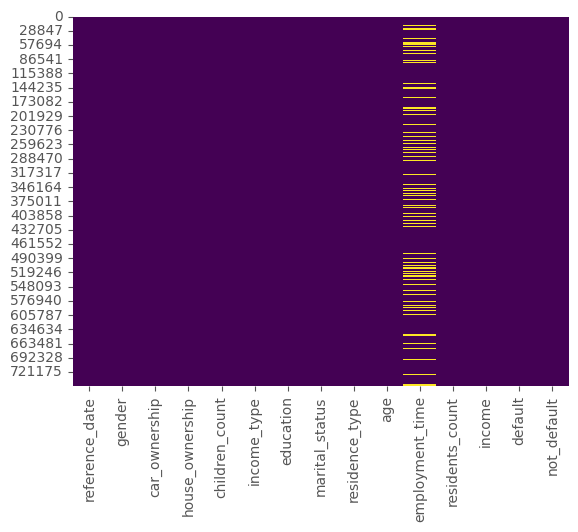

In [405]:
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.show()

The only variable that has missing values is "employment-time". The missing values are well distributed throughout the data.

Here, we are going to fill the missing values with the mean values using the following function:

In [408]:
def fill_missing_with_mean(df):
    # Select only columns with missing values to reduce overhead
    cols_with_missing = df.columns[df.isnull().any()]
    
    # Fill missing values only in those columns
    for col in cols_with_missing:
        df[col].fillna(df[col].mean(), inplace=True)
    
    return df

In [409]:
df_filled = fill_missing_with_mean(df)

In [410]:
df.isna().sum()

reference_date     0
gender             0
car_ownership      0
house_ownership    0
children_count     0
income_type        0
education          0
marital_status     0
residence_type     0
age                0
employment_time    0
residents_count    0
income             0
default            0
not_default        0
dtype: int64

### Performing the split

In [412]:
df_train = df[df['reference_date'] <= '2015-12-31']
df_oot = df[df['reference_date'] >= '2016-01-01']

In [413]:
print(df_train.shape)

(600000, 15)


In [414]:
print(df_oot.shape)

(150000, 15)


- The train dataset has 600,000 entries
- The Out-of-Time dataset has 150,000 entries

---

<div style="background-color: #15616d; color: white; padding: 20px; border-radius: 10px;">
    <h1 style="text-align: center; font-family: 'Arial', sans-serif;">🔍 Univariate Analysis</h1>
    <p style="font-size: 1.2em; text-align: center;">
        The univariate analysis performed in this step aims to highlight imbalances and important features present in our dataset. Here, we use the functions defined in the previous step to do the heavy lifting for us.
    </p>
</div>

---
>

---


### Let's start by performing an univariate analysis with the categorical data from our dataset. Here, we are using the 'univ_plot' function that we have set earlier.

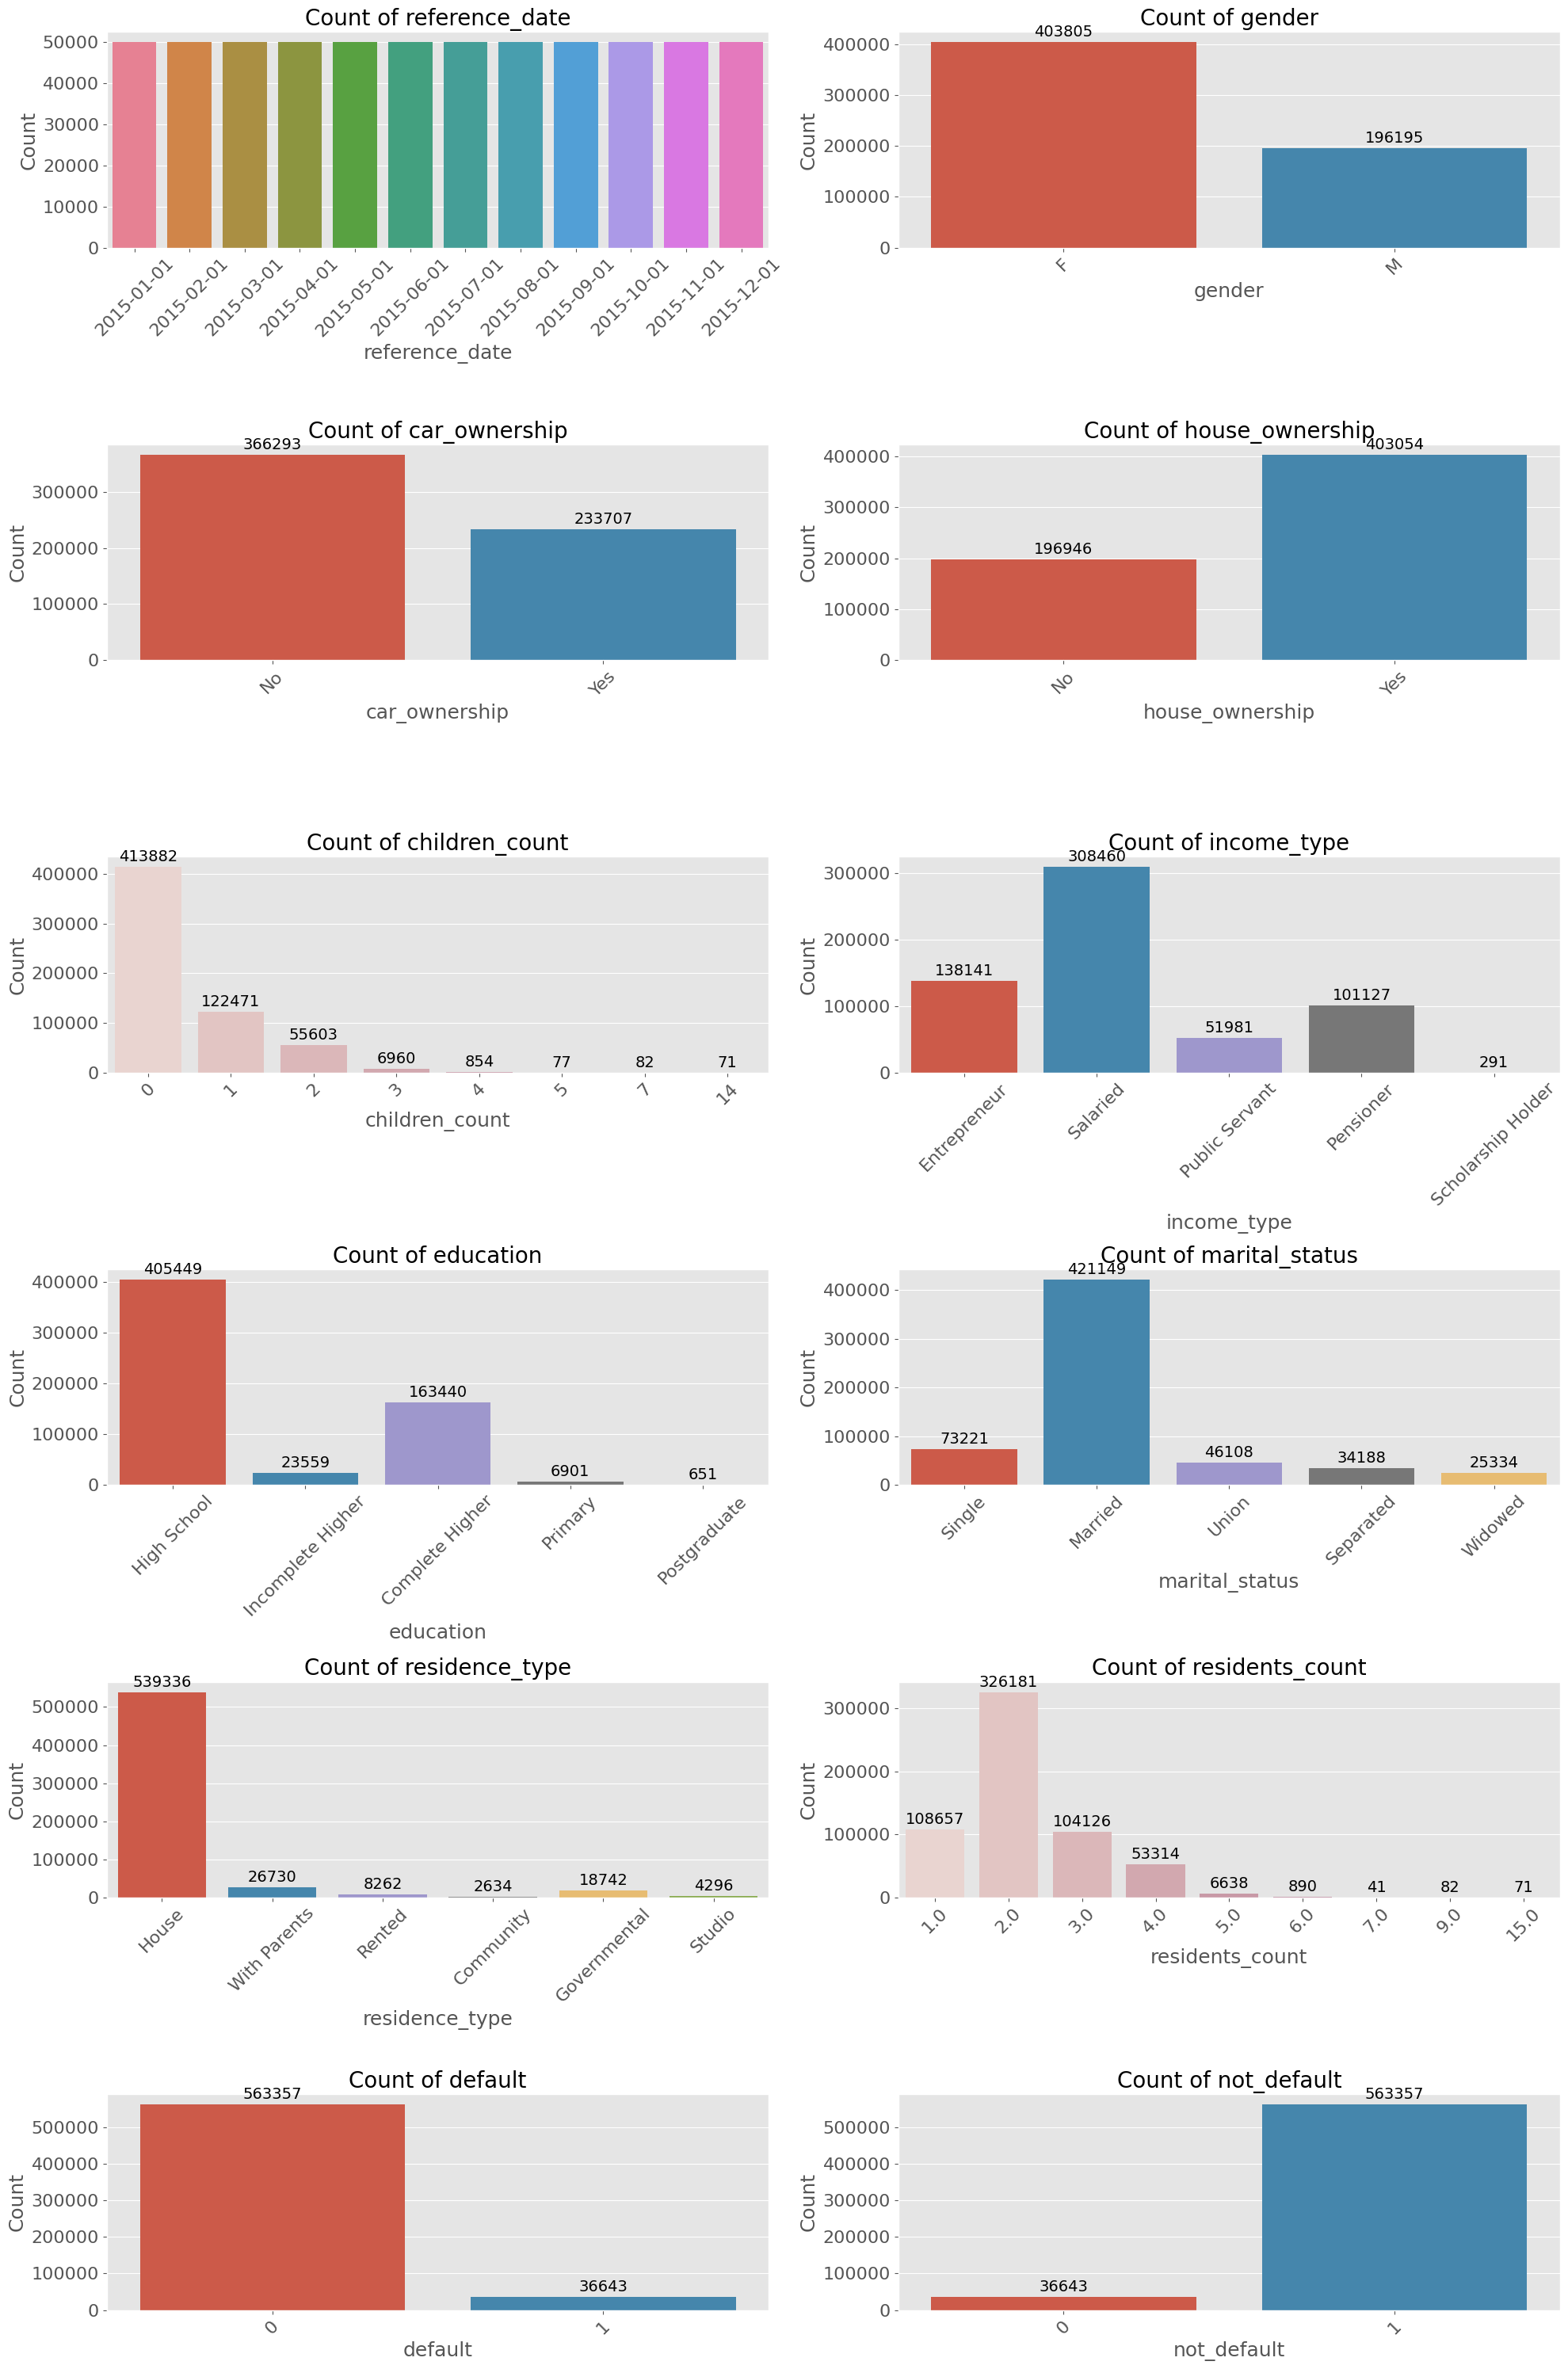

CPU times: total: 18.9 s
Wall time: 26.5 s


In [418]:
%%time
univ_plot(df_train)

### **Reference Date**- **Balance**: Data collection is balanced across all months (2015/01/01 - 2015/12/01).

### **Gender**
- **Imbalance**: Significant, with a higher proportion of Female records.
- **Potential Impact**: Could bias the model towards predicting outcomes more accurately for the majority gender.

### **Car Ownership**
- **Imbalance**: Majority of records indicate no car ownership.
- **Potential Impact**: May skew predictions towards non-car owners.

### **House Ownership**
- **Imbalance**: Majority of records show house ownership.
- **Potential Impact**: Model may favor predictions for homeowners.

### **Children Count**
- **Imbalance**: Most records have zero children.
- **Potential Impact**: Could lead to a model that underestimates outcomes for larger families.

### **Income Type**
- **Imbalance**: Dominance of salaried individuals.
- **Potential Impact**: Model might be biased towards outcomes typical for salaried individuals.

### **Education**
- **Imbalance**: High School education is the most common.
- **Potential Impact**: Model could overrepresent outcomes typical for this education level.

### **Marital Status**
- **Imbalance**: Most records are for married individuals.
- **Potential Impact**: May lead to biased predictions favoring married individuals.

### **Residence Type**
- **Imbalance**: Majority live in houses.
- **Potential Impact**: Model may underrepresent outcomes for those in other residence types.

### **Residents Count**
- **Imbalance**: Most households have 1 or 2 residents.
- **Potential Impact**: Larger households may be underrepresented in predictions.

### **Default Status**
- **Imbalance**: Most records indicate no default.
- **Potential Impact**: The model may struggle to predict defaults accurately.


### Let's now perform an univariate analysis with the continuous data from our dataset. Here, we are using the 'univ_plot' function that we have set earlier.

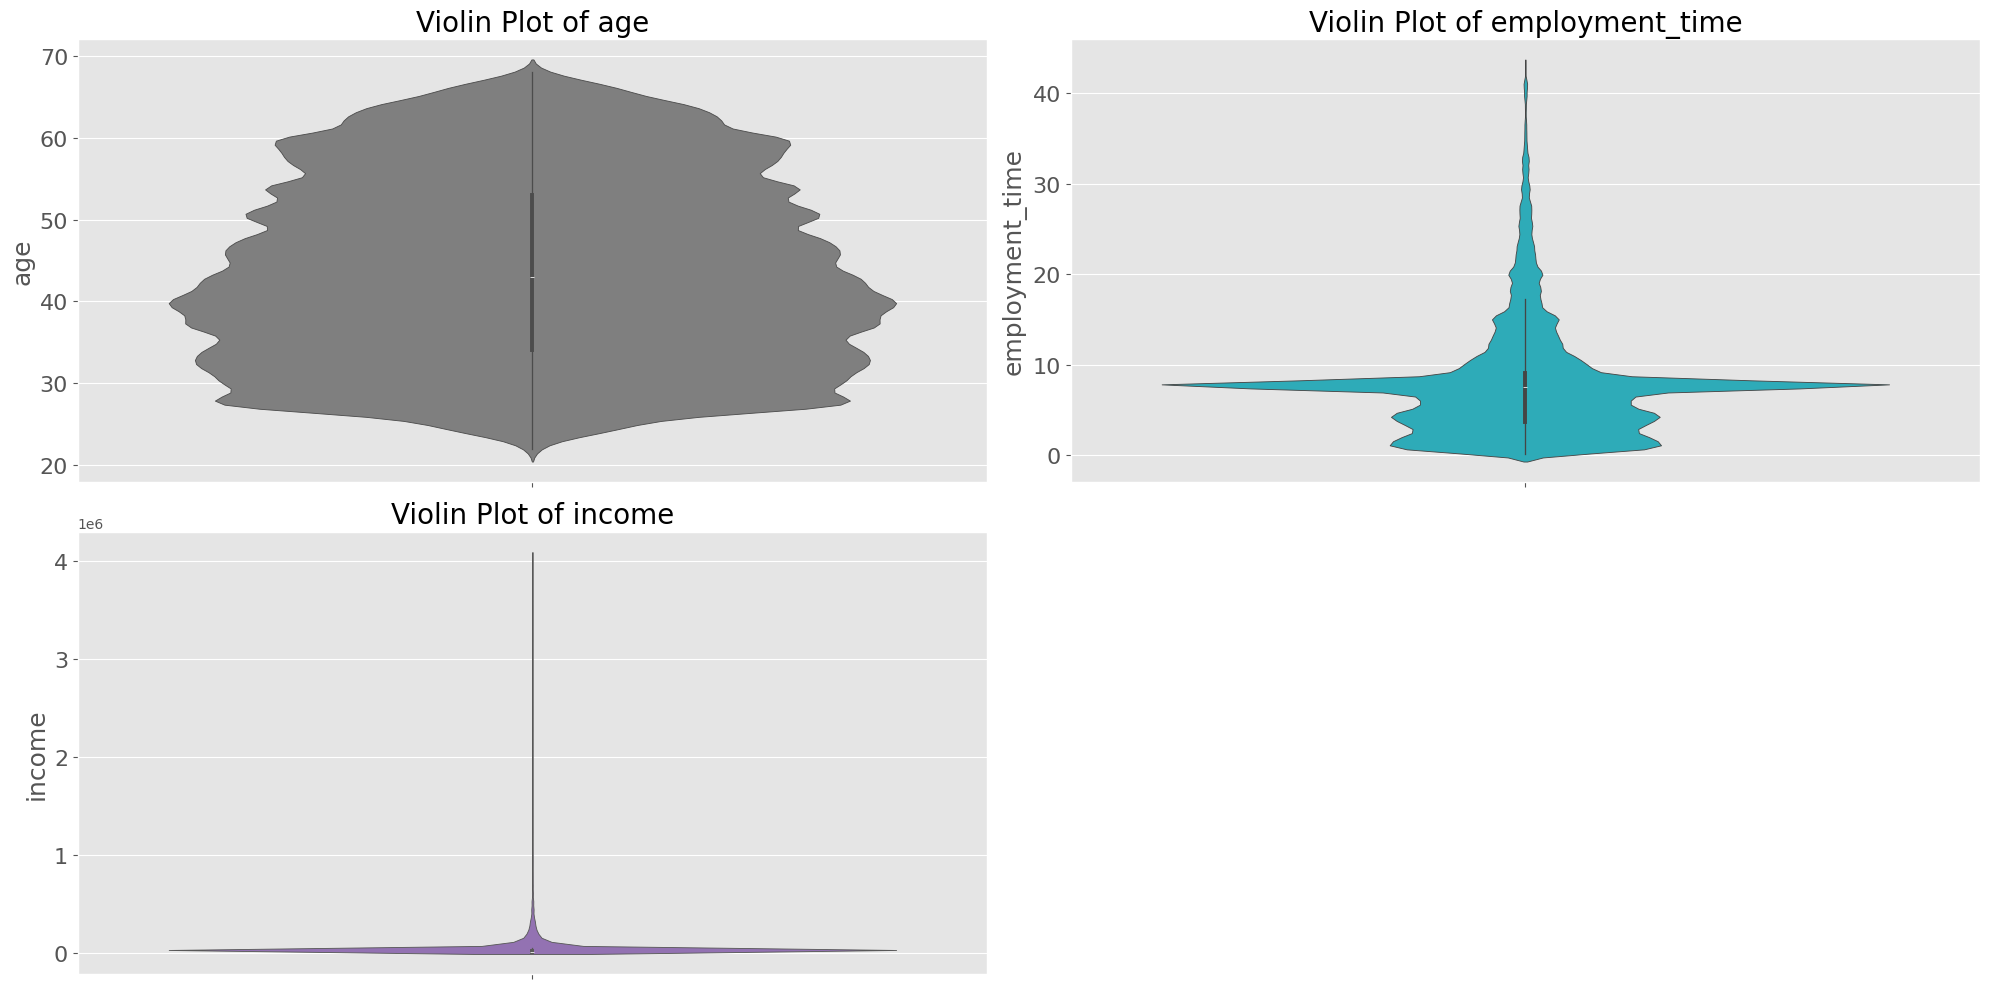

In [421]:
univ_plot(df_train, categorical=False)

### **Age**

- **Distribution**: The age distribution appears to be fairly symmetrical, with most individuals clustered between **30 to 50 years**.
- **Potential Impact**: The model may perform well across different age groups, with no evident skew towards a particular age range.

### **Employment Time**

- **Distribution**: The distribution is skewed towards lower employment times, with a peak near the beginning of employment and a long tail extending to longer employment durations.
- **Potential Impact**: The model may emphasize early employment periods, potentially underestimating the influence of long-term employment.

### **Income**

- **Distribution**: The income distribution is highly skewed, with a large number of individuals earning low to moderate incomes and a very few earning exceptionally high incomes.
- **Potential Impact**: This skewness may cause the model to underperform in predicting outcomes for high-income individuals, as they are underrepresented.


---

<div style="background-color: #15616d; color: white; padding: 20px; border-radius: 10px;">
    <h1 style="text-align: center; font-family: 'Arial', sans-serif;">🔍 Bivariate Analysis</h1>
    <p style="font-size: 1.2em; text-align: center;">
        The bivariate analysis performed on this step aims to highlight some of the relationships between key variables for our model.
    </p>
</div>

---
>


### For reference: Let's calculate the "baseline" % of default in our train set.

In [425]:
total = 563357 + 36643
default_percentage = (36643 / total) * 100
print(default_percentage)

6.107166666666667


### *Around 6.1%*

### **Default Rates by Gender in the Training Set**

<Figure size 1000x600 with 0 Axes>

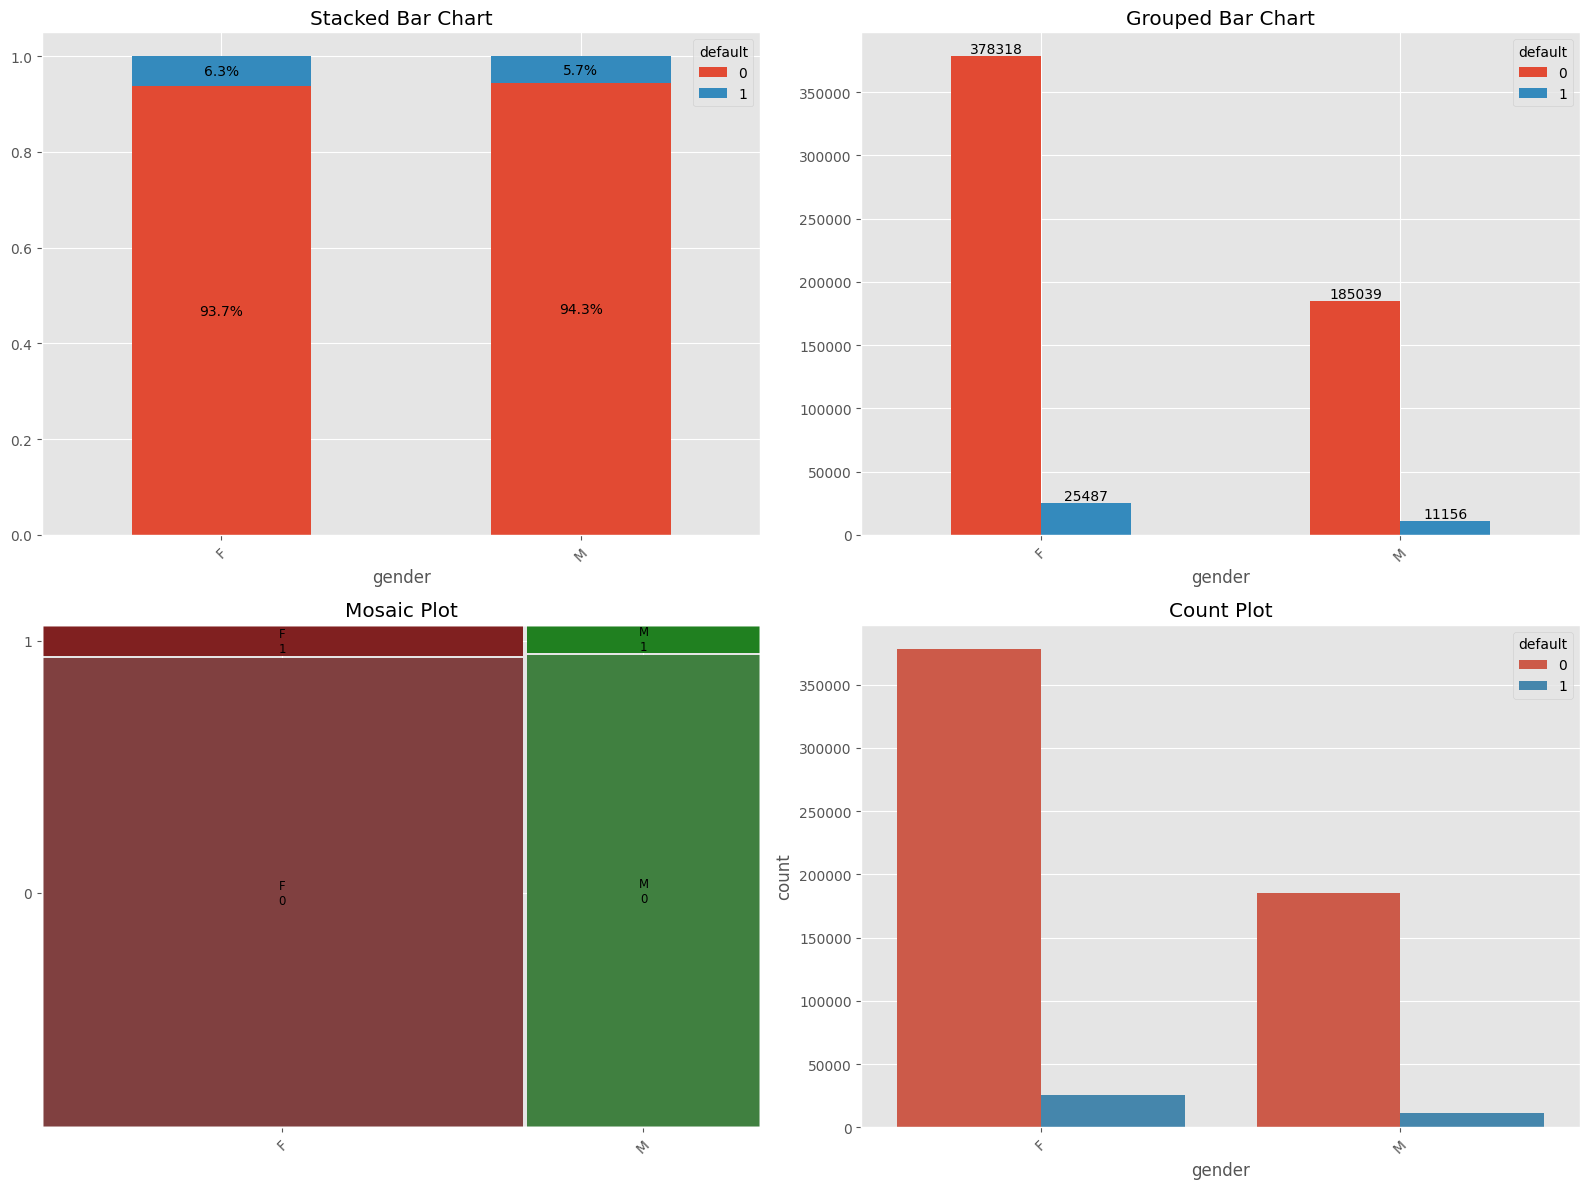

In [428]:
biv_plot(df_train, x='gender', y='default', threshold=15)

- **Female Default Rate**: **6.3%**
- **Male Default Rate**: **5.7%**

This observation indicates a slightly higher tendency for females to default compared to males in our training dataset.


---

### **Default Rates by Car Ownership**

<Figure size 1000x600 with 0 Axes>

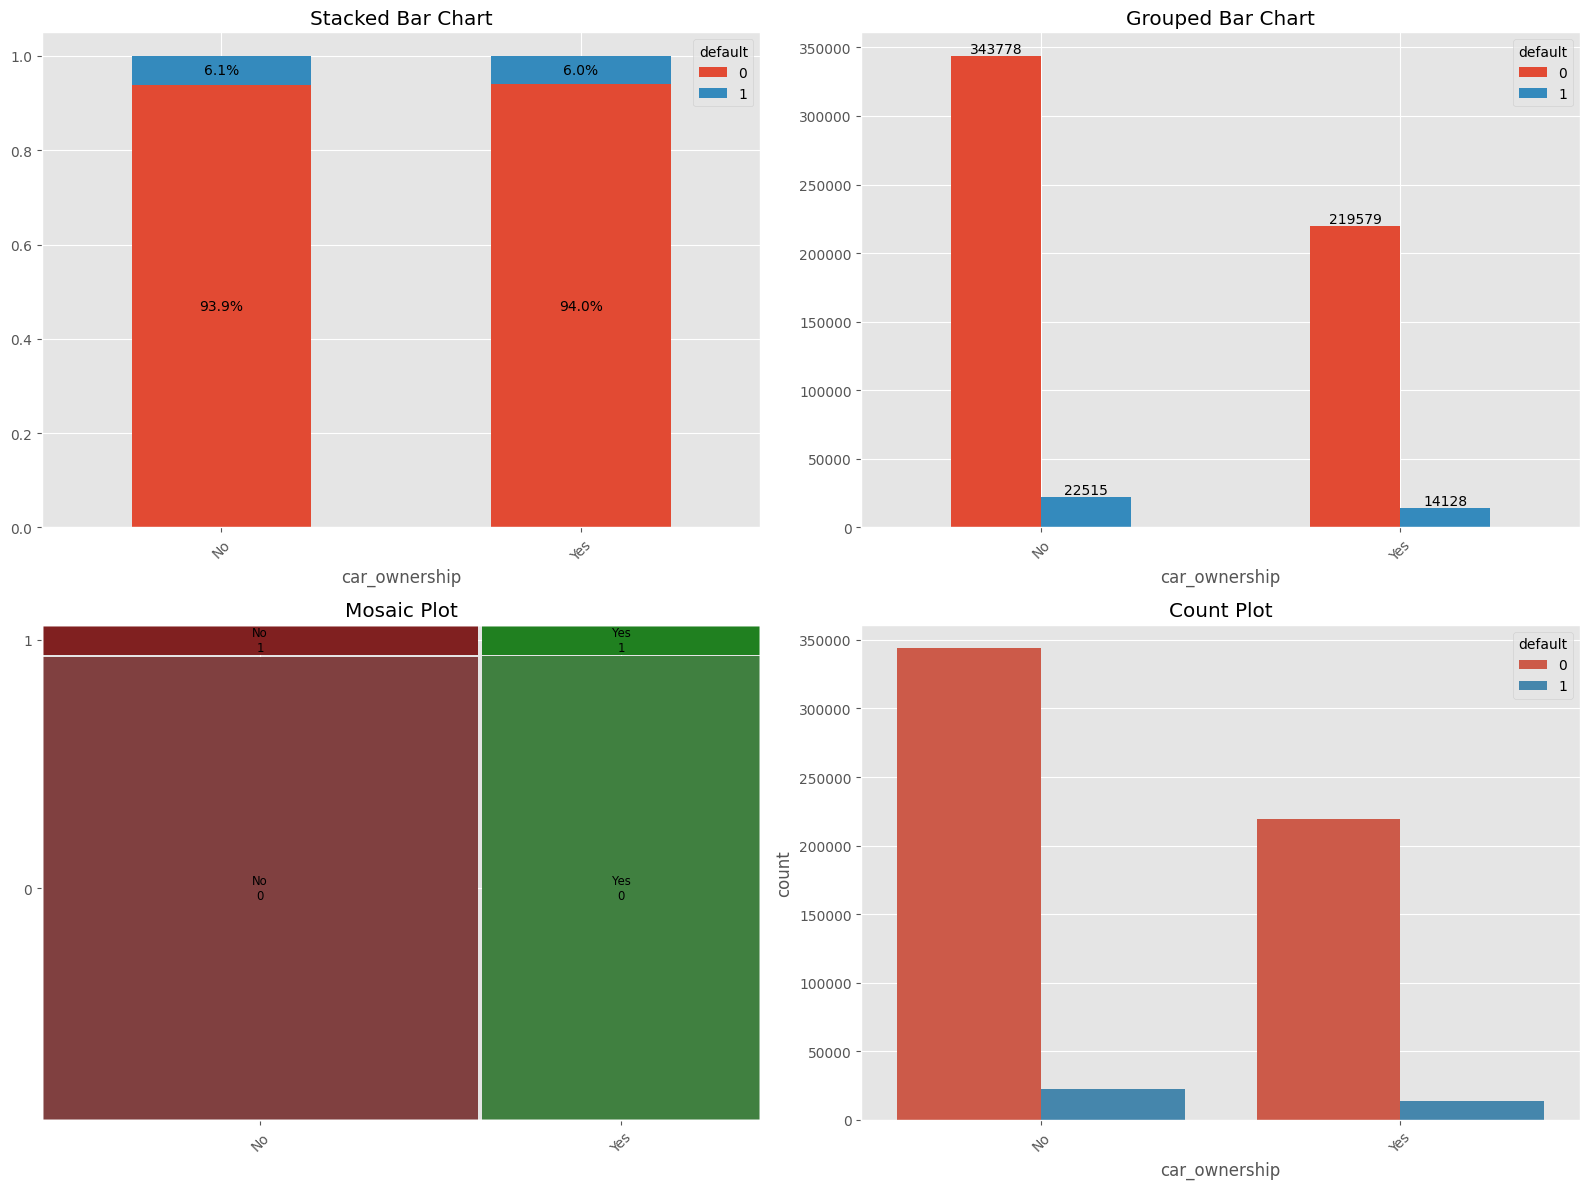

In [432]:
biv_plot(df_train, x='car_ownership', y='default', threshold=15)

This comparison shows a very slight difference in default rates between individuals who own a car and those who do not. The distribution of defaults is almost identical, regardless of car ownership.

---

### **Default Rates by Number of Children**

<Figure size 1000x600 with 0 Axes>

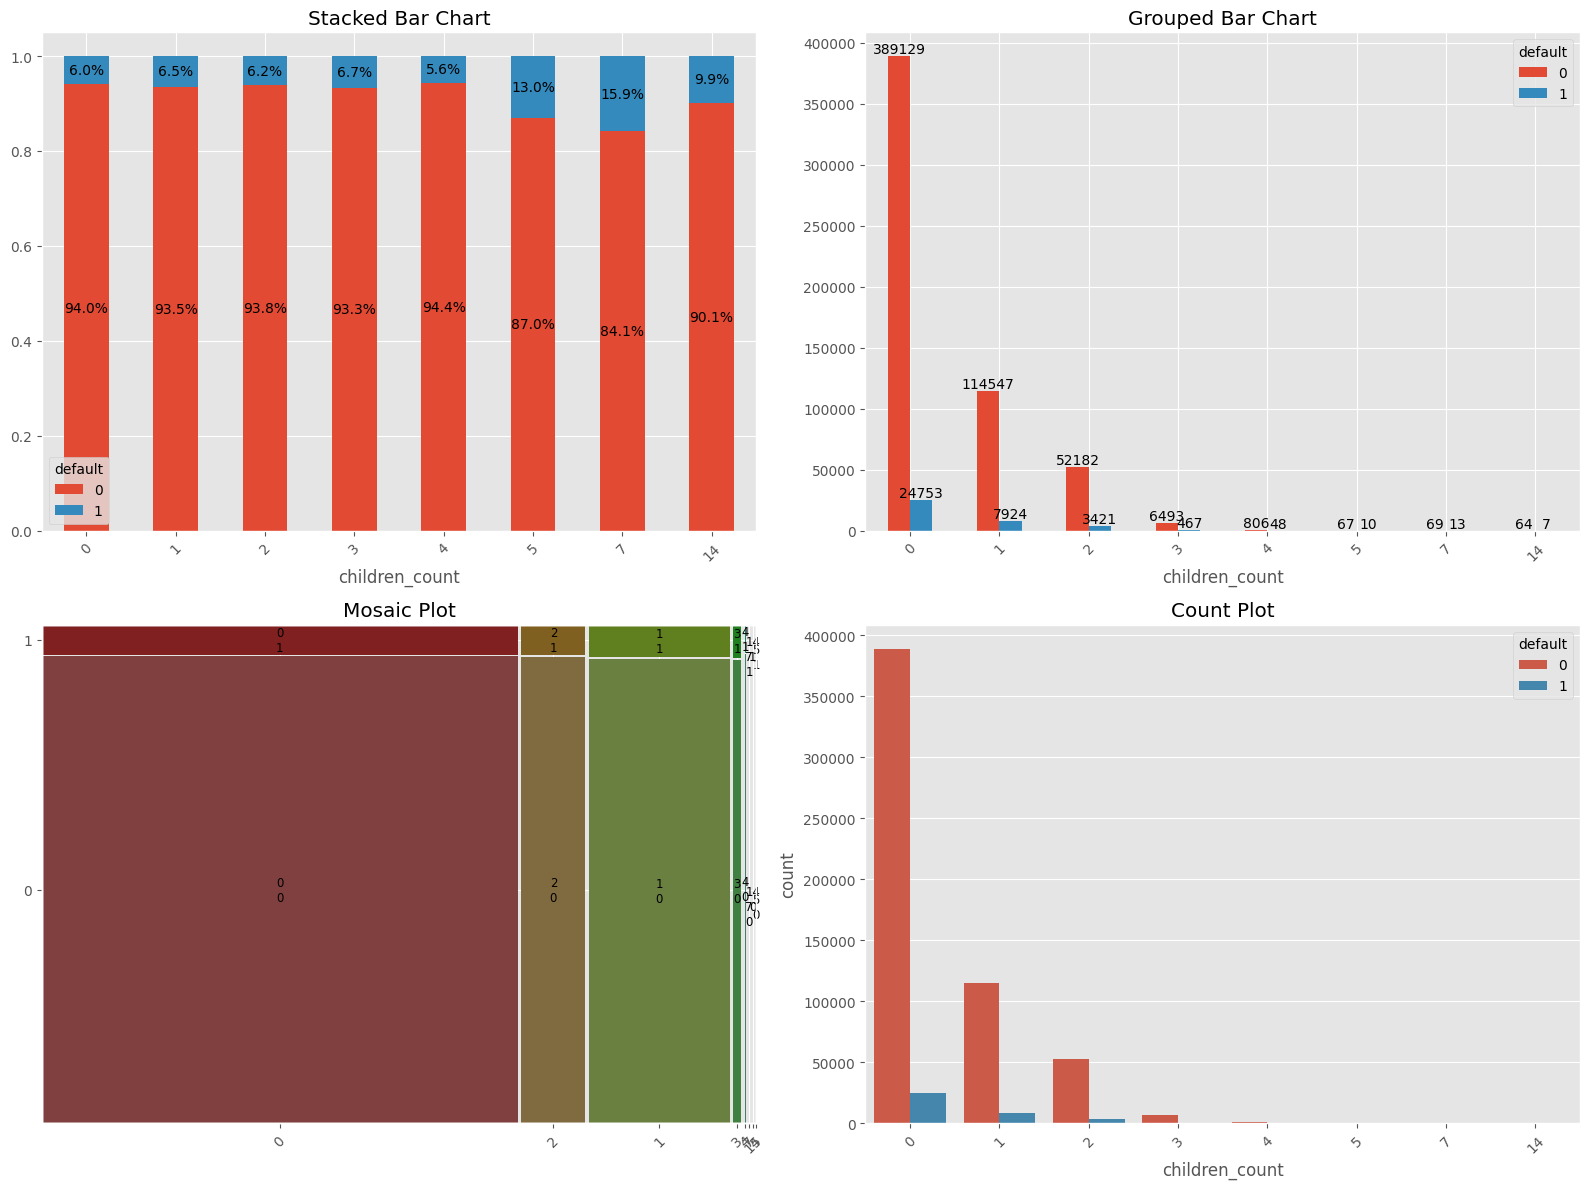

In [436]:
biv_plot(df_train, x='children_count', y='default', threshold=15)

This analysis shows that the default rate tends to increase with the number of children, particularly for those with 5 or more children, suggesting a potential higher financial strain in larger households. It is important to consider that due to the imbalance of the data, the default rates for families that have more than 3 children may not be very reliable.

Values that are too small, may be merged together in order to reduce potential biases towards discrepant values that may arise from a small sample.

---

### **Default Rates by Income Type**

<Figure size 1000x600 with 0 Axes>

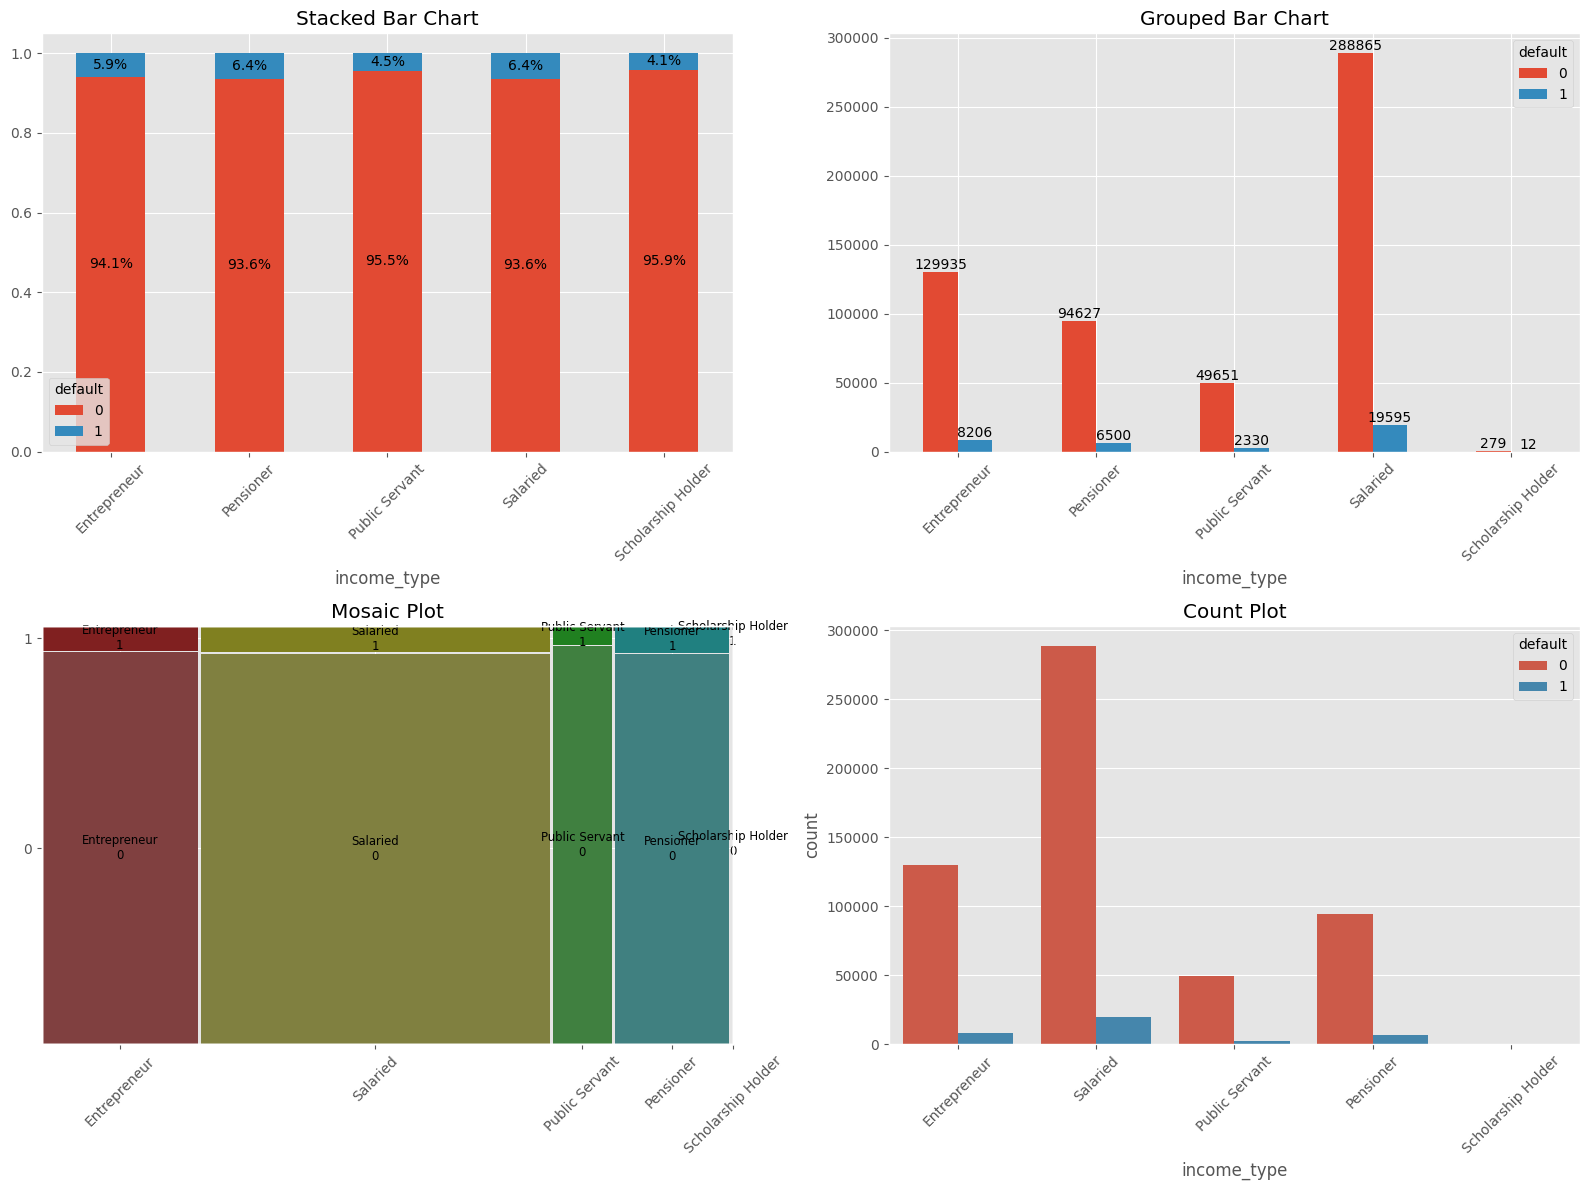

In [441]:
biv_plot(df_train, x='income_type', y='default', threshold=15)

This analysis reveals that **Pensioners** and **Salaried** individuals have slightly higher default rates compared to **Public Servants** and **Scholarship Holders**, who exhibit lower default rates. The differences in default rates across income types can provide valuable insights into financial stability within each group.

Values that are too small, may be merged together in order to reduce potential biases towards discrepant values that may arise from a small sample value.

---

### **Default Rates by Education Level**

<Figure size 1000x600 with 0 Axes>

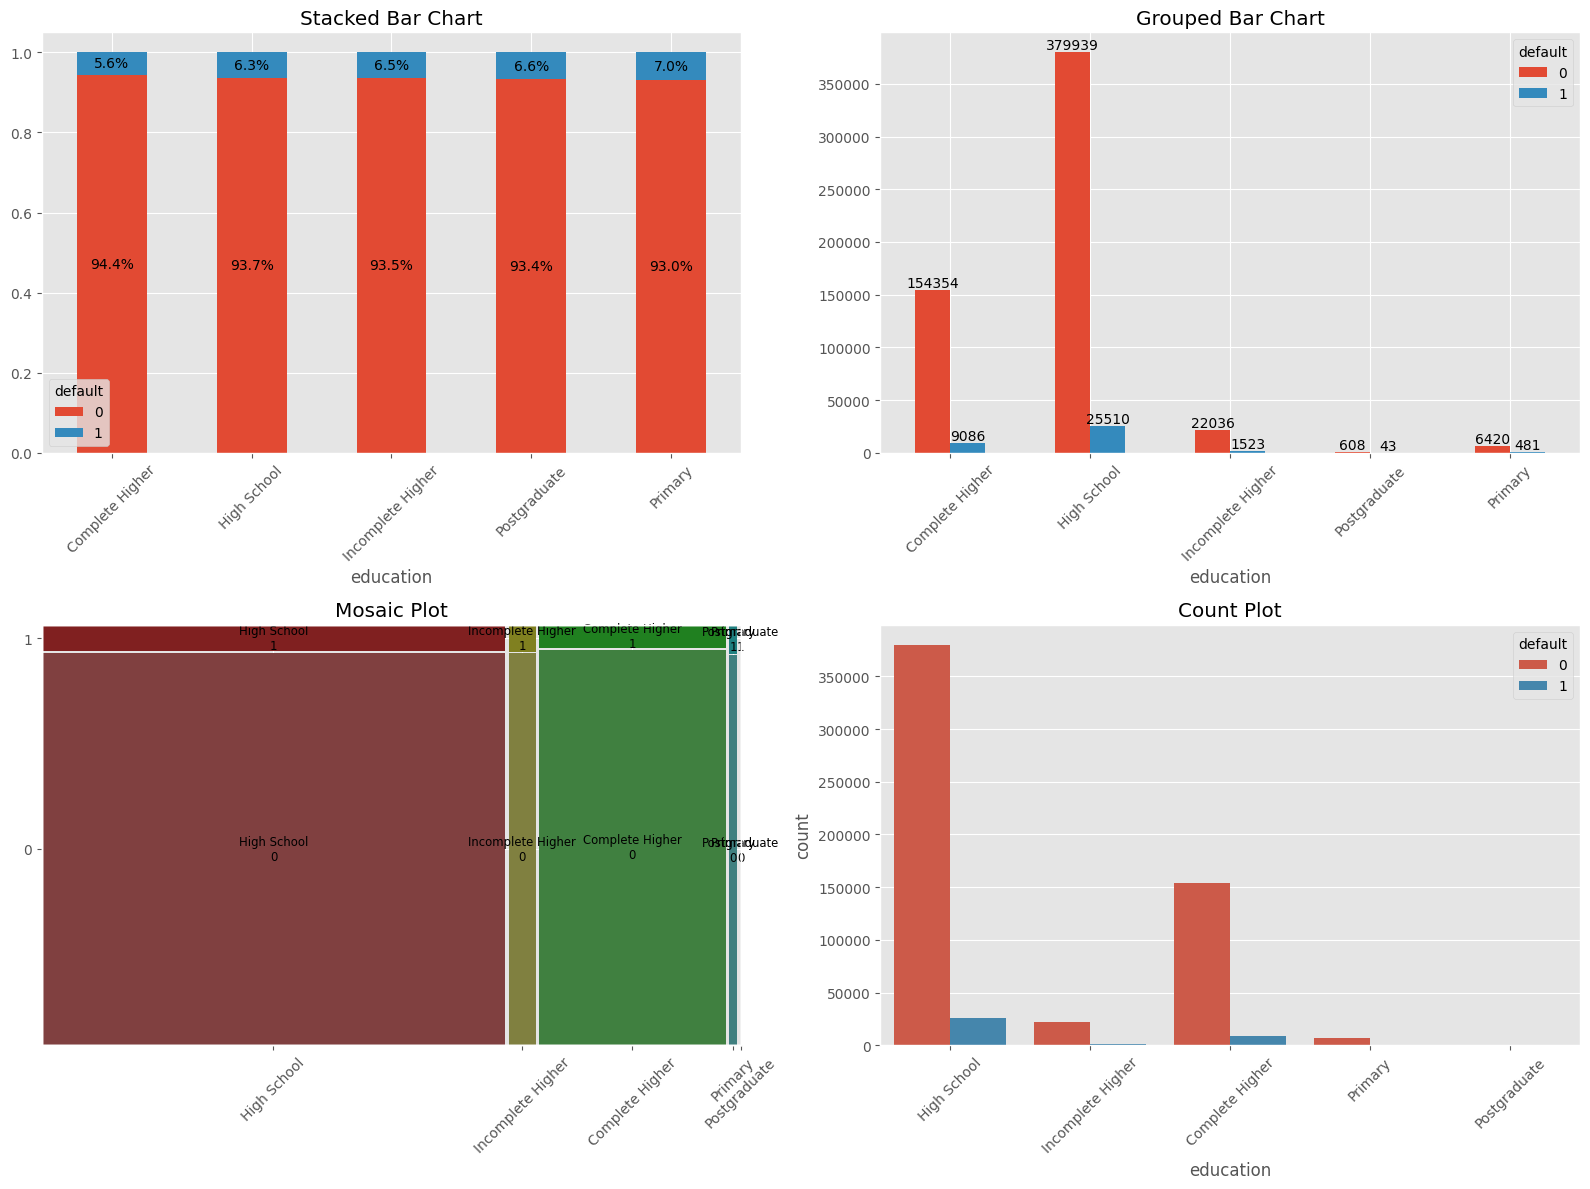

In [446]:
biv_plot(df_train, x='education', y='default', threshold=15)


This analysis highlights that individuals with **Primary** education have the highest default rate, while those with a **Complete Higher** education have the lowest default rate. The data suggests a potential correlation between higher education levels and a lower likelihood of default.

---

### **Default Rates by Marital Status**

<Figure size 1000x600 with 0 Axes>

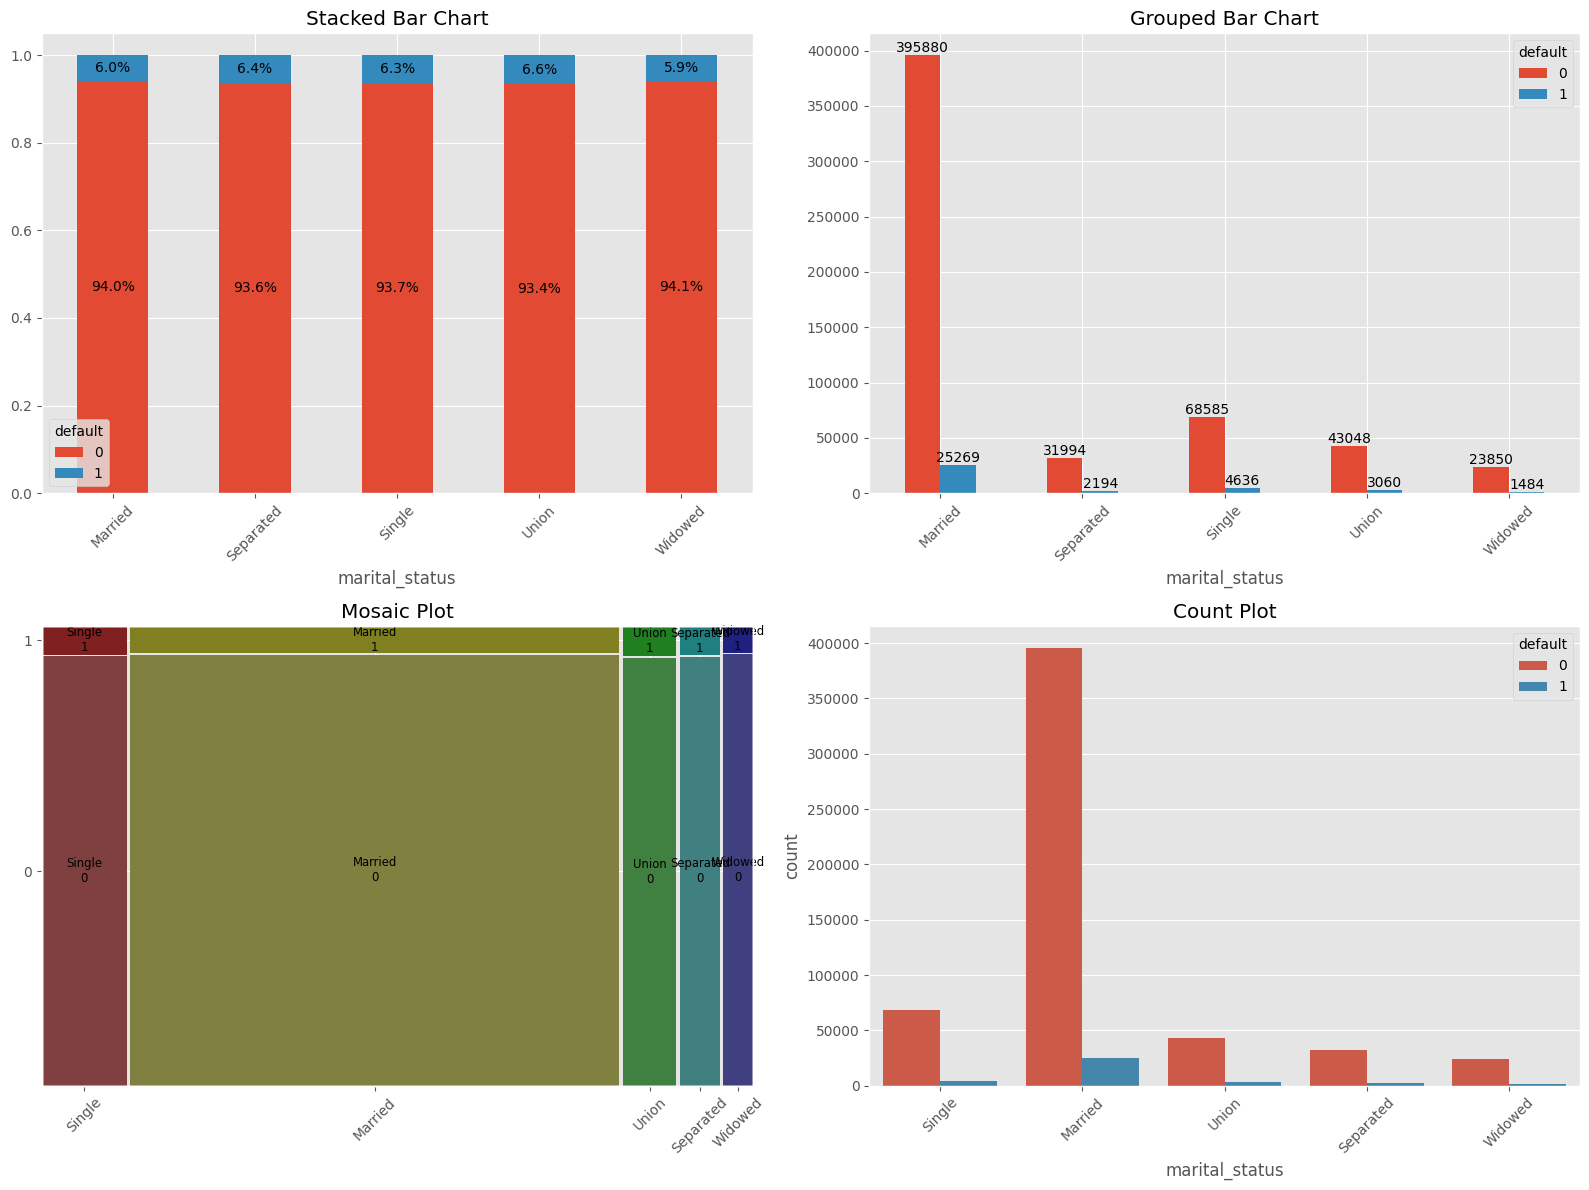

In [450]:
biv_plot(df_train, x='marital_status', y='default', threshold=15)


The analysis shows slight variations in default rates across different marital statuses. Individuals in a **Union** and those who are **Separated** have slightly higher default rates, while **Widowed** individuals have the lowest default rate among the groups.

---

### **Default Rates by Residence Type**

<Figure size 1000x600 with 0 Axes>

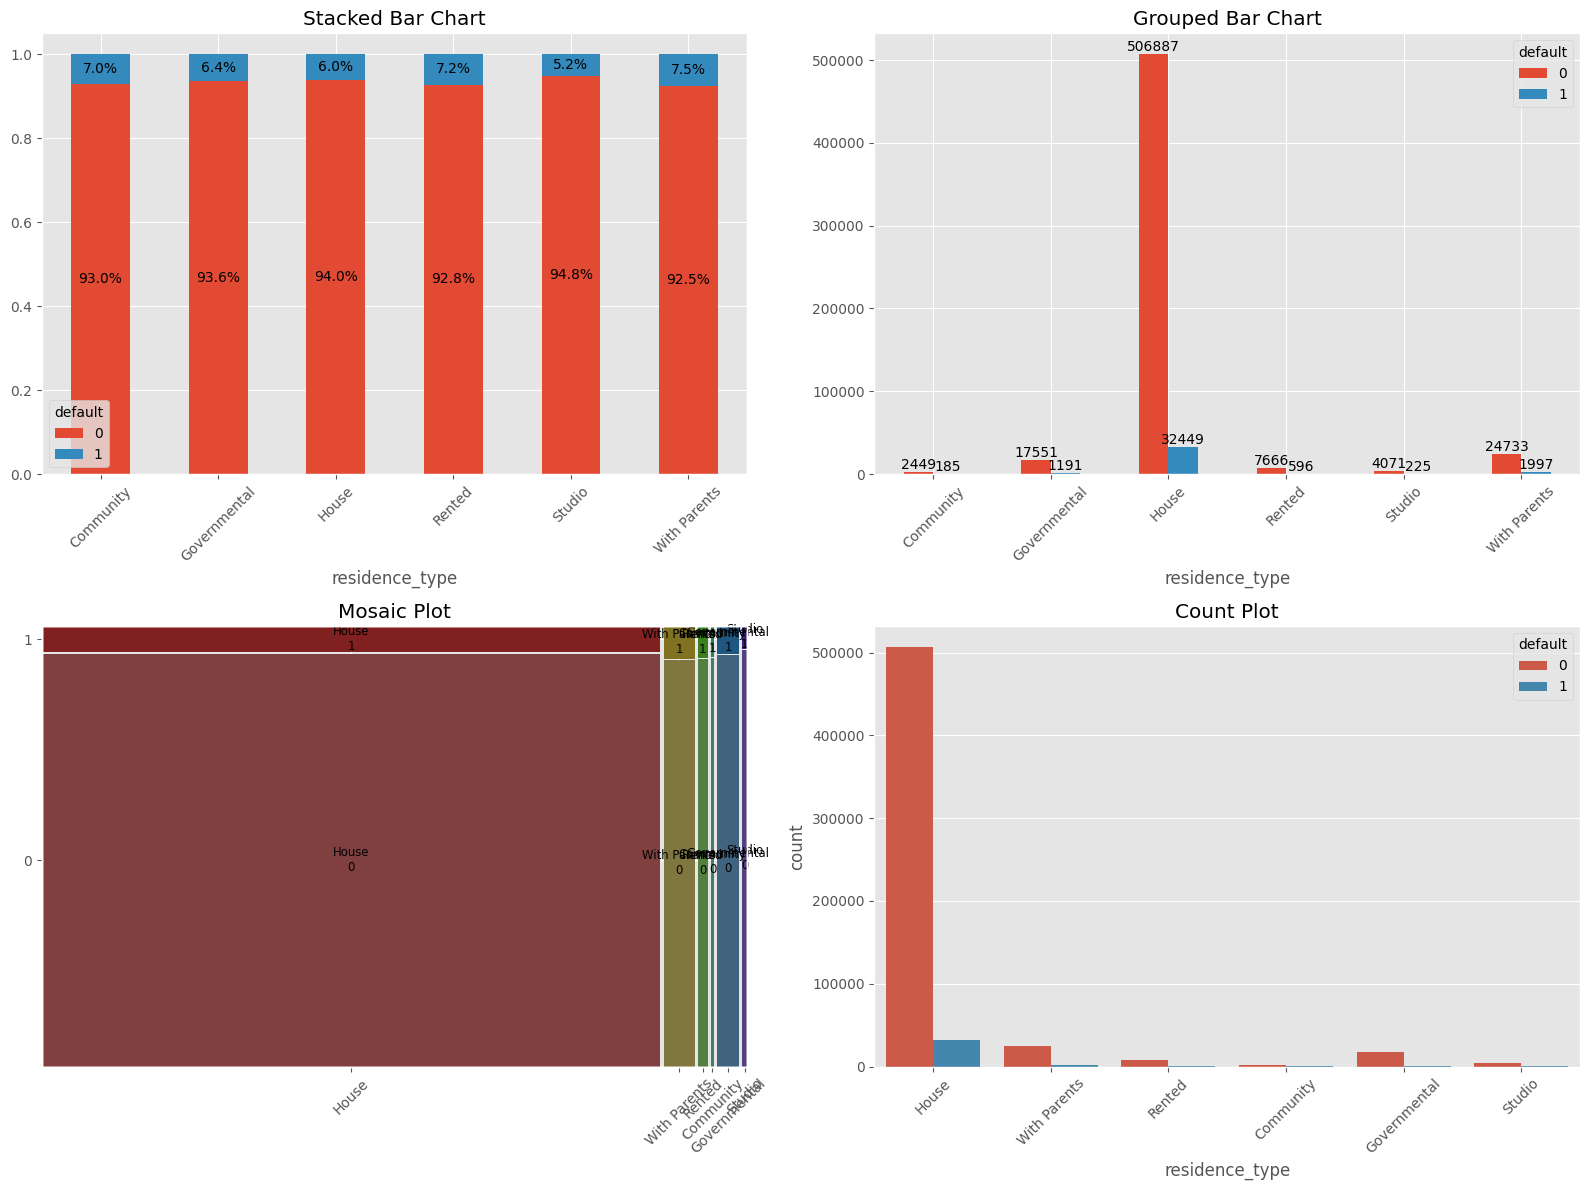

In [454]:
biv_plot(df_train, x='residence_type', y='default', threshold=15)


This analysis shows that individuals living **With Parents** and in **Rented** properties have the highest default rates, while those living in **Studios** have the lowest default rate. The type of residence appears to have some correlation with the likelihood of default.

---

### **Default Rates by Number of Residents**

<Figure size 1000x600 with 0 Axes>

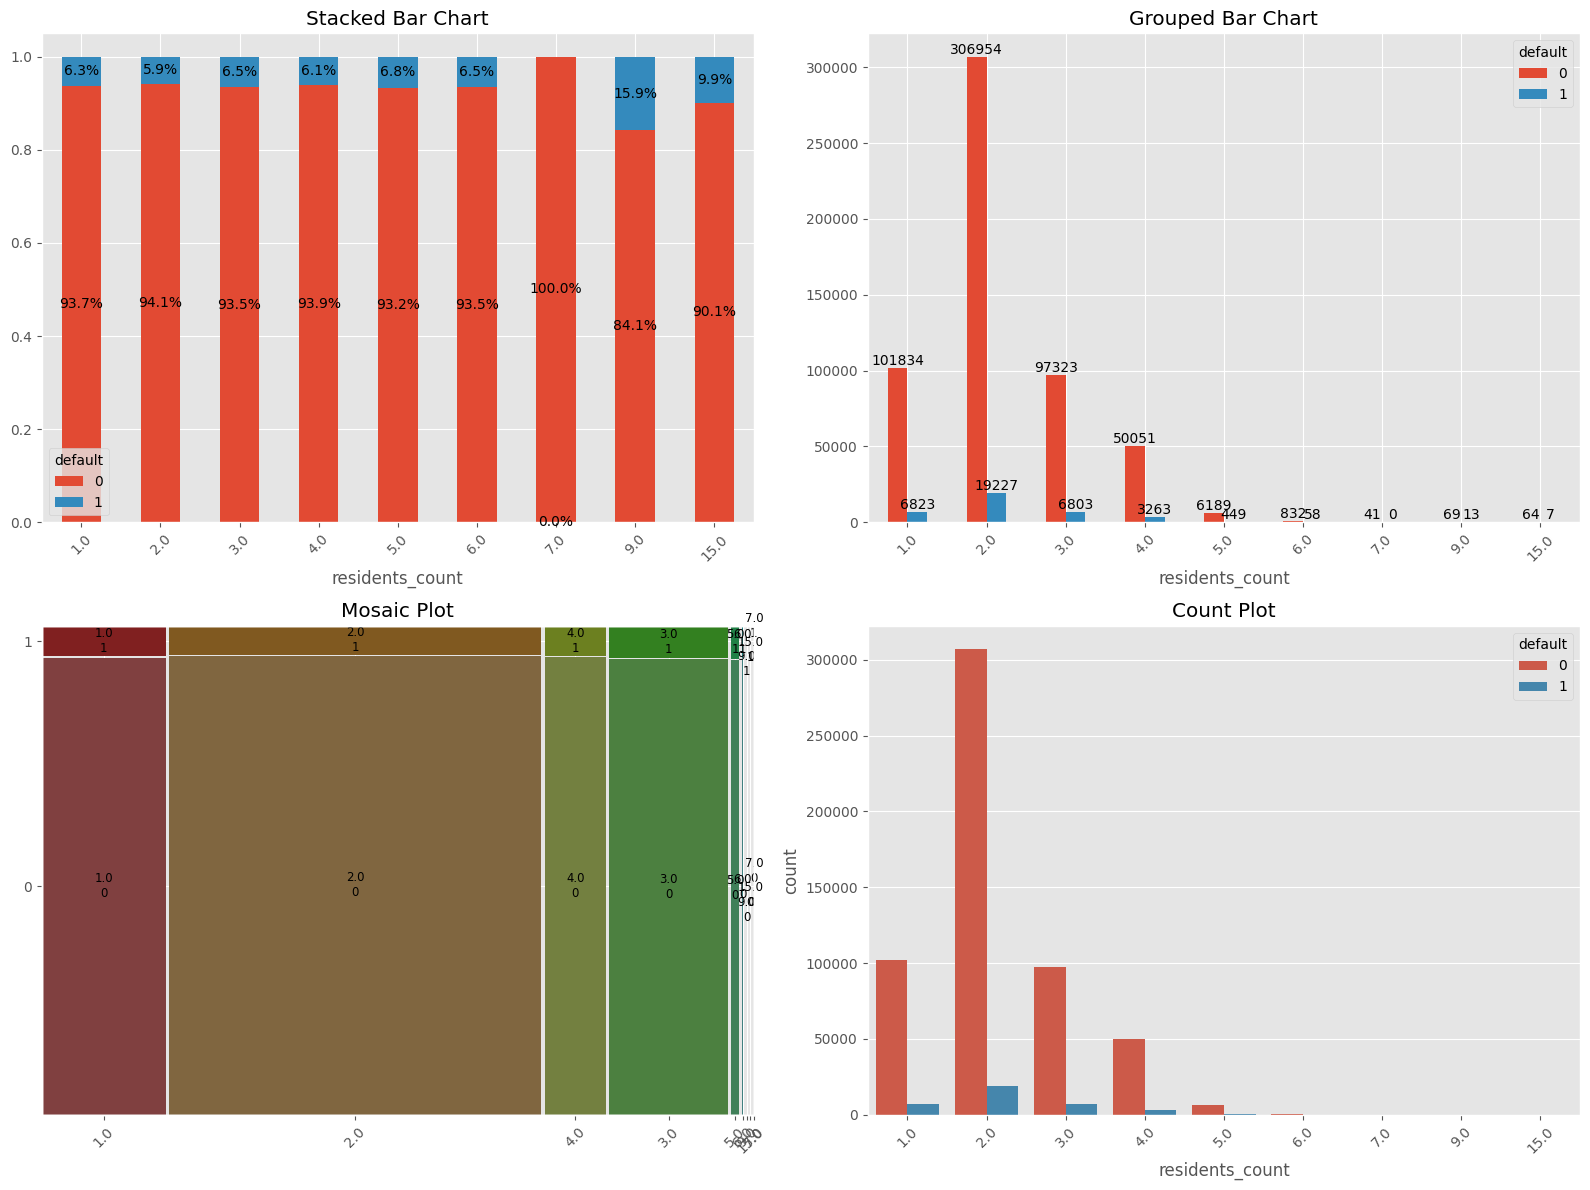

In [458]:
biv_plot(df_train, x='residents_count', y='default', threshold=15)


### **Impact of Structural Zero**

The **7 Residents** category shows a **0.0% default rate**. This is an example of a **structural zero**, meaning that no defaults were observed in the data for households with exactly 7 residents. Structural zeros can occur due to data limitations or specific conditions within the dataset.

### **Implications of Structural Zero:**

1. **Model Bias**:
   - The presence of a structural zero can lead to bias in the model, particularly if the model interprets the lack of defaults in this category as a strong indicator of no risk, which may not be accurate in a broader context.

2. **Data Sparsity**:
   - Structural zeros often occur due to a lack of sufficient data in certain categories. This can make it difficult for the model to learn meaningful patterns from these categories, leading to unreliable predictions.

3. **Misinterpretation**:
   - It’s crucial to recognize structural zeros as artifacts of the dataset rather than definitive trends. Without proper interpretation, the model might give undue confidence to categories with structural zeros.

Overall, while the default rates generally increase with a higher number of residents, the structural zero for 7 residents requires careful consideration to avoid misleading the model's performance and interpretation.


---

### Default Rates by Age

<Figure size 1000x600 with 0 Axes>

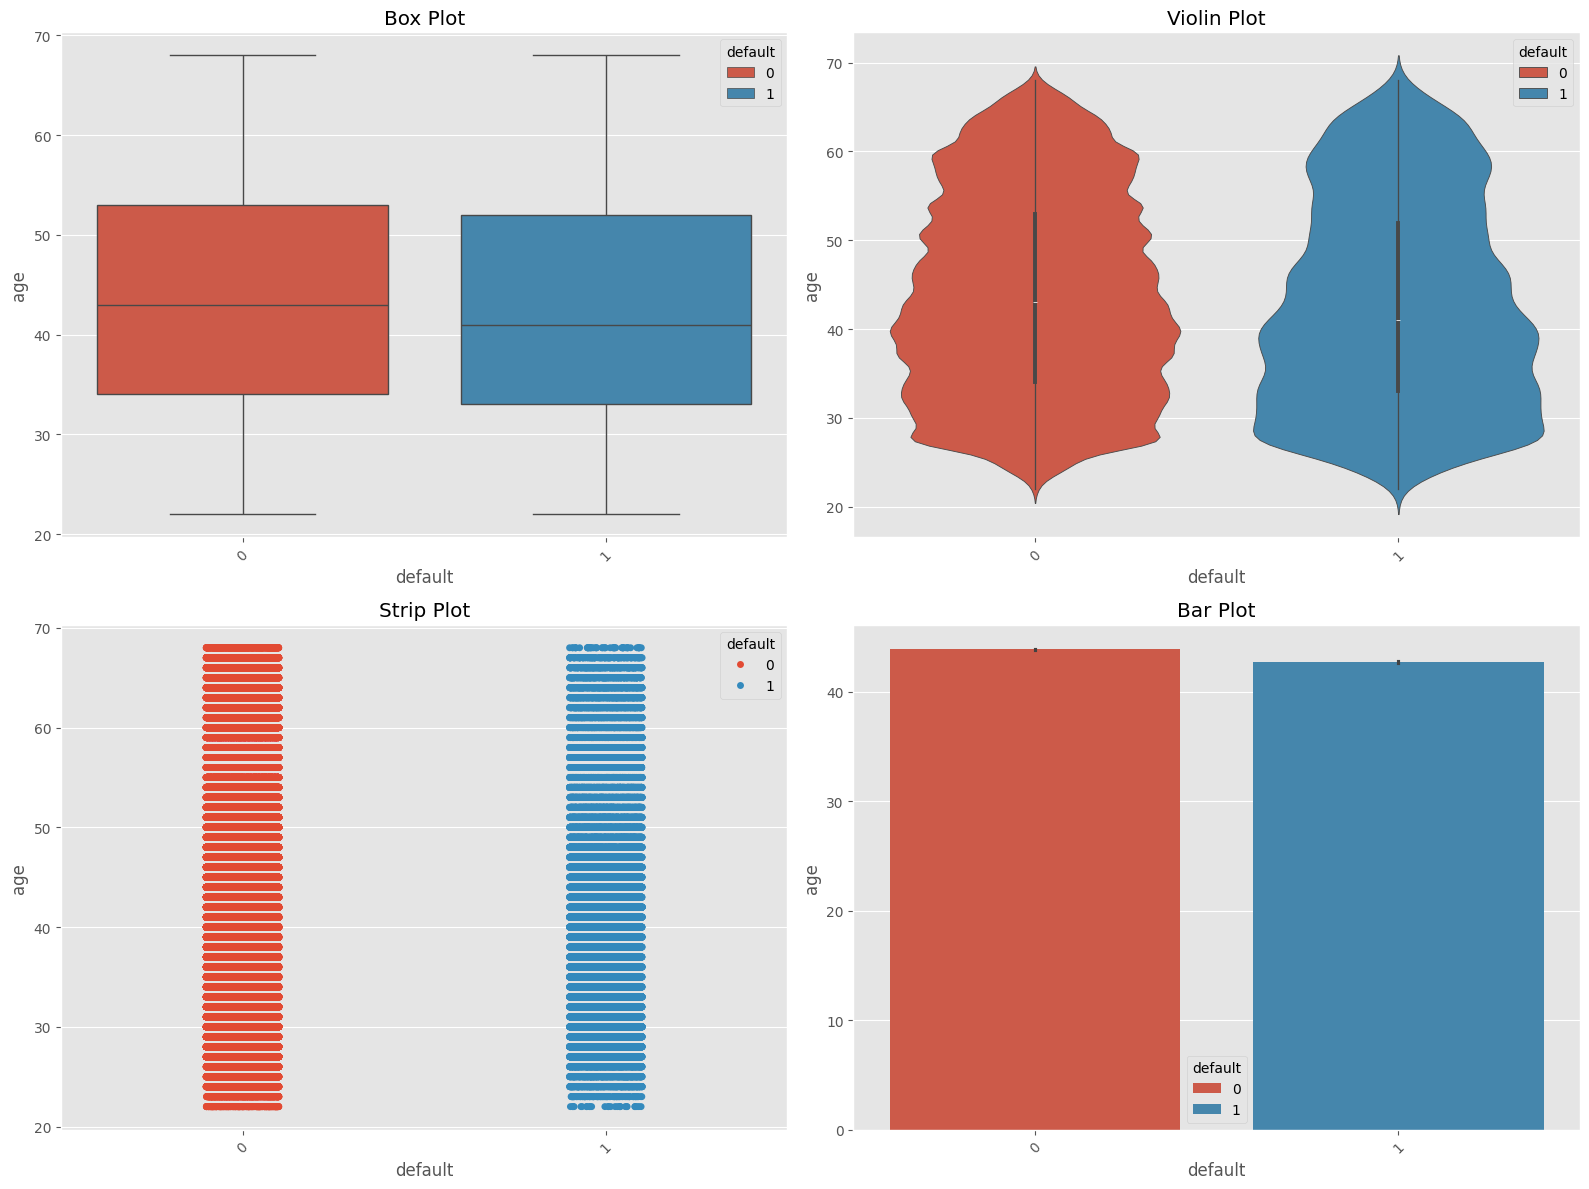

In [462]:
biv_plot(df_train, x='age', y='default', threshold=15)

The plots suggest that age is not a decisive factor in determining whether an individual defaults, as the density distributions for both defaulted (True) and non-defaulted (False) individuals are nearly identical. However, the box plot reveals that individuals who defaulted tend to be slightly younger on average compared to those who did not default.


---

### Default Rates by Employment Time

<Figure size 1000x600 with 0 Axes>

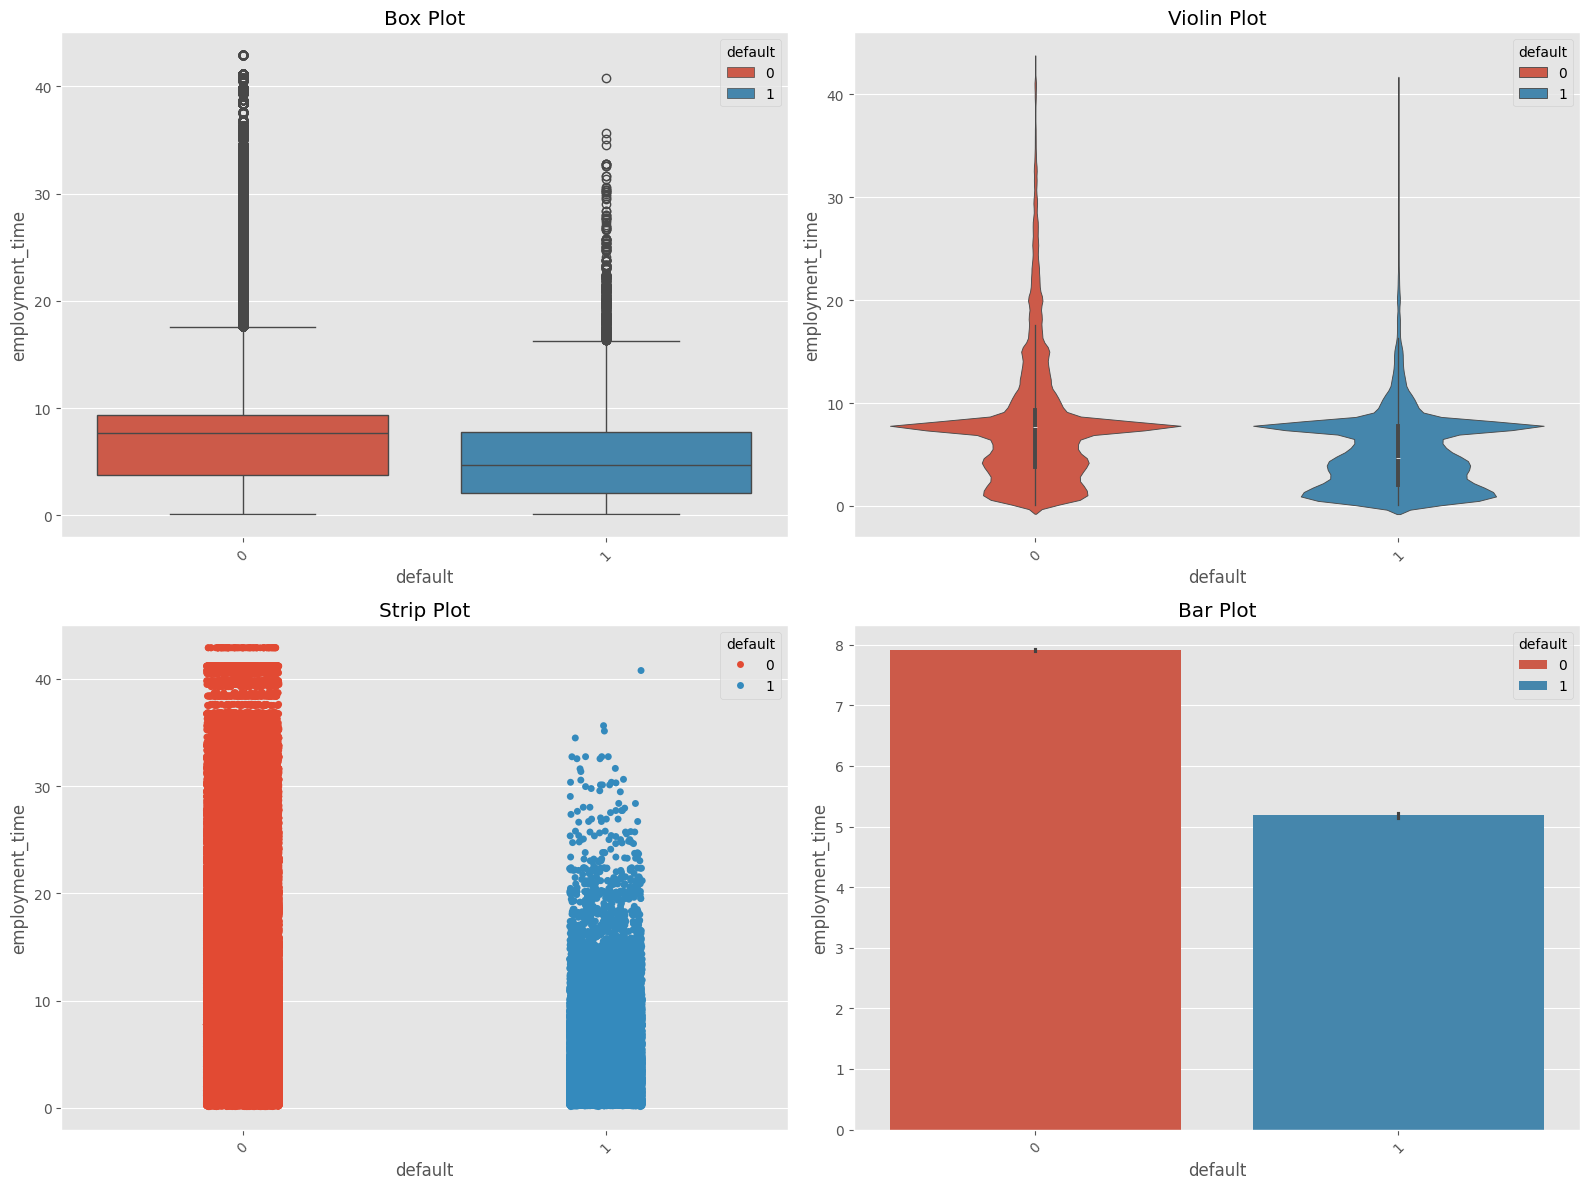

In [466]:
biv_plot(df_train, x='employment_time', y='default', threshold=15)

50% of individuals who defaulted have between 0 and 6 years of employment time. Beyond this period, default rates tend to decrease, suggesting a correlation between longer employment time and better credit score outcomes.


---

<div style="background-color: #15616d; color: white; padding: 20px; border-radius: 10px;">
    <h1 style="text-align: center; font-family: 'Arial', sans-serif;">🧪 Data Preparation & Preprocessing</h1>
    <p style="font-size: 1.2em; text-align: center;">
        For this step, we are going to perform several operations in order to make our data fit to the Logistic Regression model we want to train.
    </p>
</div>

---


### Data Preparation and Preprocessing steps:

1. Cleaning Missing Values<br>
2. Treating Structural Zeros<br>
3. Treating Outliers<br>
4. Creating Dummies (One-Hot Encoding)<br>
5. Data Normalization<br>
6. Principal Component Analysis (PCA)<br>
7. Feature Selection

## 1. Cleaning Missing Values

We have already perfomed this step earlier defining the function "fill_missing_with_mean()"

---

Since we have already performed the first step, we are going to start with: </br>
## 2. Treating Structural Zeros

#### a) Defining a function to calculate the Information Value (IV)
The Information Value (IV) metric measures the predictive power of an independent variable in distinguishing between binary outcomes (e.g., good vs. bad credit). It helps identify the most significant predictors for a model, with higher IV values indicating stronger predictive capability.

 There is a rule-of-thumb that is widely accepted of how the value of a variable is reflected by its IV, see for example Naeem Siddiqi.  This is shown in the table below:

<div style="text-align: center;">
  <img src="https://github.com/PedroHang/Credit-Scoring-Project/blob/main/Images/IV.png?raw=true" alt="OOT" width="300"/>
</div>


#### We are defining a function that calculates Information Value (IV) based on WOE: </br>

<b>Weight of Evidence (WOE)</b> is a measure used in statistics and machine learning to quantify the predictive power of a feature by comparing the distribution of that feature across different classes

In [479]:
def IV(x, y):
    # Create a crosstab to calculate the frequency distribution of x and y
    table = pd.crosstab(x, y, margins=True, margins_name='total')

    # Get the labels for the event and non-event categories
    event_label = table.columns[0]
    non_event_label = table.columns[1]

    # Calculate the percentage of events
    table['pct_event'] = table[event_label] / table.loc['total', event_label]
    table['event_proportion'] = table[event_label] / table.loc['total', event_label]

    # Calculate the percentage of non-events
    table['pct_non_event'] = table[non_event_label] / table.loc['total', non_event_label]

    # Calculate Weight of Evidence (WoE)
    table['woe'] = np.log(table.pct_event / table.pct_non_event)

    # Calculate the partial Information Value (IV)
    table['iv_partial'] = (table.pct_event - table.pct_non_event) * table.woe

    # Return the sum of the partial IVs as the total Information Value
    return table['iv_partial'].sum()

#### b) Creating a metadata table

Having this metadata allows us to properly preprocess our data, ensuring that it meets the requirements of logistic regression and improving the overall quality and interpretability of the model.

In [481]:
metadata = pd.DataFrame(df_filled.dtypes, columns=['dtype'])
metadata['nmissing'] = df_filled.isna().sum()
metadata['unique_values'] = df_filled.nunique()
metadata['role'] = 'covariate'
metadata.loc['default','role'] = 'response'
metadata.loc['not_default','role'] = 'response'
metadata

,dtype,nmissing,unique_values,role
reference_date,datetime64[ns],0,15,covariate
gender,object,0,2,covariate
car_ownership,object,0,2,covariate
house_ownership,object,0,2,covariate
children_count,int64,0,8,covariate
income_type,object,0,5,covariate
education,object,0,5,covariate
marital_status,object,0,5,covariate
residence_type,object,0,6,covariate
age,int64,0,47,covariate


#### c) Calculating the Information Value for each of the variables

In [497]:
for var in metadata[metadata.role=='covariate'].index:
    if  (metadata.loc[var, 'unique_values']>6):
        metadata.loc[var, 'IV'] = IV(pd.qcut(df_filled[var],5,duplicates='drop'), df_filled.default)
    else: 
        metadata.loc[var, 'IV'] = IV(df_filled[var], df_filled.default)

    
metadata

,dtype,nmissing,unique_values,role,IV
reference_date,datetime64[ns],0,15,covariate,0.345982
gender,object,0,2,covariate,0.002185
car_ownership,object,0,2,covariate,0.000108
house_ownership,object,0,2,covariate,0.009693
children_count,int64,0,8,covariate,0.000030
income_type,object,0,5,covariate,0.009360
education,object,0,5,covariate,0.003547
marital_status,object,0,5,covariate,0.001126
residence_type,object,0,6,covariate,0.003045
age,int64,0,47,covariate,0.017968


In [499]:
metadata['IV'].sort_values(ascending=False)

income             1.068628
reference_date     0.345982
employment_time    0.278819
age                0.017968
house_ownership    0.009693
income_type        0.009360
education          0.003547
residence_type     0.003045
gender             0.002185
residents_count    0.001346
marital_status     0.001126
car_ownership      0.000108
children_count     0.000030
default                 NaN
not_default             NaN
Name: IV, dtype: float64

The Income variable has the highest Information Value (IV) at 1.06, which places it in the "suspicious" category according to our IV scale. This high IV suggests that Income is closely aligned with predicting whether a client defaults or not across most of the data. However, due to the presence of several outliers, the reliability of this variable is questionable. To enhance the trustworthiness of this variable, it is crucial to address and treat these outliers before using it for prediction.

Reference Date may not be used for prediction because it may lead to strong biases given that the dates have already been used to split the data.



#### d) Plotting graphs, Removing Structural Zeros and grouping similar Categories

Here we are defining a function that helps us with plotting the graphs that indicate the presence of Structural Zeros.

In [615]:
def biv_discrete(var, df_filled):
    df_filled['not_default'] = 1 - df_filled.default
    g = df_filled.groupby(var)

    biv = pd.DataFrame({'qt_not_default': g['not_default'].sum(),
                        'qt_default': g['default'].sum(),
                        'default': g['default'].mean(),
                        var: g['default'].mean().index, 
                        'cont': g[var].count()})
    
    biv['ep'] = (biv.default * (1 - biv.default) / biv.cont) ** .5
    biv['default_sup'] = biv.default + t.ppf([0.975], biv.cont - 1) * biv.ep
    biv['default_inf'] = biv.default - t.ppf([0.025], biv.cont - 1) * biv.ep
    
    biv['logit'] = np.log(biv.default / (1 - biv.default))
    biv['logit_sup'] = np.log(biv.default_sup / (1 - biv.default_sup))
    biv['logit_inf'] = np.log(biv.default_inf / (1 - biv.default_inf))

    general_default_rate = df_filled.default.mean()
    general_woe = np.log(df_filled.default.mean() / (1 - df_filled.default.mean()))

    biv['woe'] = biv.logit - general_woe
    biv['woe_sup'] = biv.logit_sup - general_woe
    biv['woe_inf'] = biv.logit_inf - general_woe

    fig, ax = plt.subplots(2, 1, figsize=(8, 6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='superior limit')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='inferior limit')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat - .7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar(ax=ax[1])

    # Adding count labels on top of each bar
    for p in ax[1].patches:
        ax[1].annotate(f'{int(p.get_height())}', 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha='center', va='center', 
                       xytext=(0, 10), 
                       textcoords='offset points')
    
    return biv


I am also making a copy of the df_filled so that we can treat the structural zeros without modifying our "original" dataframe.

In [618]:
df_struc = df_filled.copy()

,qt_not_default,qt_default,default,income_type,cont,ep,default_sup,default_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
income_type,,,,,,,,,,,,,,
Entrepreneur,159508,13204,0.076451,Entrepreneur,172712,0.000639,0.077704,0.077704,-2.491574,-2.473957,-2.473957,-0.024386,-0.006769,-0.006769
Pensioner,115825,10440,0.082683,Pensioner,126265,0.000775,0.084202,0.084202,-2.406436,-2.386573,-2.386573,0.060752,0.080615,0.080615
Public Servant,61151,3771,0.058085,Public Servant,64922,0.000918,0.059884,0.059884,-2.786006,-2.753587,-2.753587,-0.318818,-0.286399,-0.286399
Salaried,354527,31213,0.080917,Salaried,385740,0.000439,0.081778,0.081778,-2.429950,-2.418434,-2.418434,0.037238,0.048754,0.048754
Scholarship Holder,346,15,0.041551,Scholarship Holder,361,0.010503,0.062207,0.062207,-3.138389,-2.713068,-2.713068,-0.671200,-0.245880,-0.245880


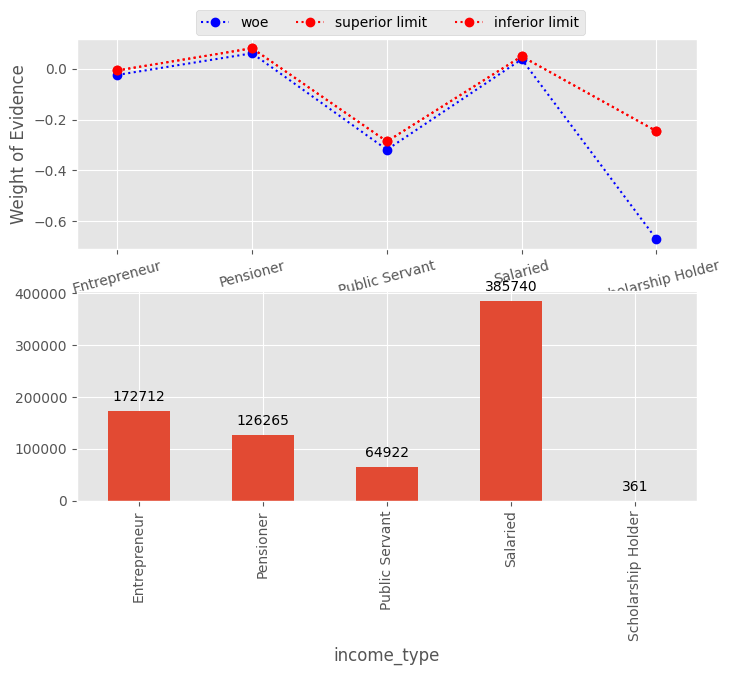

In [620]:
biv_discrete('income_type', df_struc)

Here, we can observe that the 2 categories that contribute the most to a negative WOE "Failure of the event" are "Scholarship Holder" and "Public Servant". On the other side, they are also related in terms of conceptual similarity, as both indicate individuals with stable income sources provided by the Government.

#### Let's make the substitutions and plot the new graph:

,qt_not_default,qt_default,default,income_type,cont,ep,default_sup,default_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
income_type,,,,,,,,,,,,,,
Entrepreneur,159508,13204,0.076451,Entrepreneur,172712,0.000639,0.077704,0.077704,-2.491574,-2.473957,-2.473957,-0.024386,-0.006769,-0.006769
Pensioner,115825,10440,0.082683,Pensioner,126265,0.000775,0.084202,0.084202,-2.406436,-2.386573,-2.386573,0.060752,0.080615,0.080615
Salaried,354527,31213,0.080917,Salaried,385740,0.000439,0.081778,0.081778,-2.429950,-2.418434,-2.418434,0.037238,0.048754,0.048754
Scholarship/P.Servant,61497,3786,0.057994,Scholarship/P.Servant,65283,0.000915,0.059787,0.059787,-2.787678,-2.755325,-2.755325,-0.320490,-0.288137,-0.288137


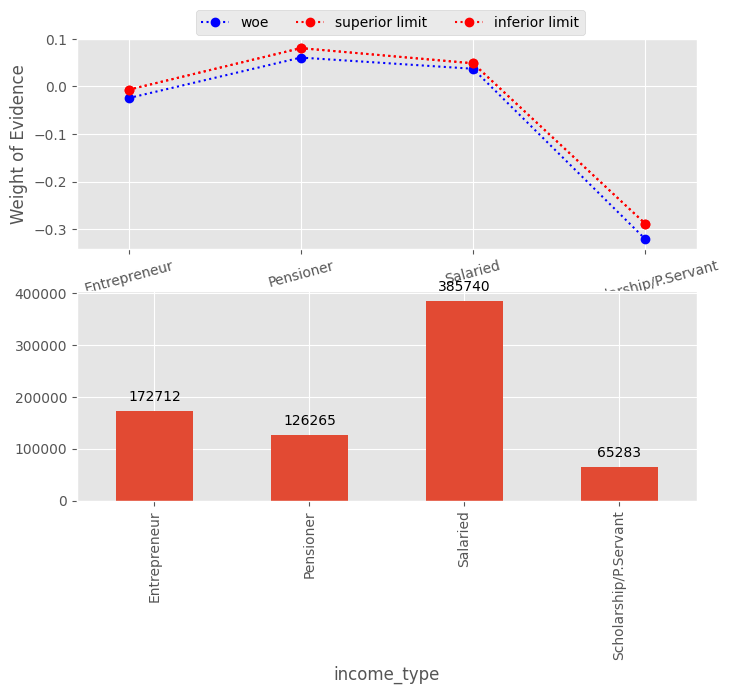

In [624]:
df_struc.income_type.replace({'Scholarship Holder': 'Scholarship/P.Servant', 'Public Servant': 'Scholarship/P.Servant'}, inplace=True)
biv_discrete('income_type', df_struc)

C:\Users\Hanga\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Hanga\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Hanga\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,qt_not_default,qt_default,default,residents_count,cont,ep,default_sup,default_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
residents_count,,,,,,,,,,,,,,
1.0,124842,10926,0.080476,1.0,135768,0.000738,0.081923,0.081923,-2.435904,-2.416508,-2.416508,0.031284,0.050680,0.050680
2.0,377007,30769,0.075456,2.0,407776,0.000414,0.076266,0.076266,-2.505756,-2.494192,-2.494192,-0.038568,-0.027004,-0.027004
3.0,119168,10900,0.083802,3.0,130068,0.000768,0.085308,0.085308,-2.391771,-2.372317,-2.372317,0.075417,0.094871,0.094871
4.0,61511,5248,0.078611,4.0,66759,0.001042,0.080653,0.080653,-2.461369,-2.433512,-2.433512,0.005819,0.033676,0.033676
5.0,7593,689,0.083192,5.0,8282,0.003035,0.089141,0.089141,-2.399741,-2.324166,-2.324166,0.067447,0.143022,0.143022
6.0,1028,80,0.072202,6.0,1108,0.007776,0.087459,0.087459,-2.553344,-2.345067,-2.345067,-0.086156,0.122121,0.122121
7.0,52,0,0.000000,7.0,52,0.000000,0.000000,0.000000,-inf,-inf,-inf,-inf,-inf,-inf
9.0,83,18,0.178218,9.0,101,0.038080,0.253767,0.253767,-1.528469,-1.078622,-1.078622,0.938719,1.388566,1.388566
15.0,73,13,0.151163,15.0,86,0.038627,0.227963,0.227963,-1.725510,-1.219851,-1.219851,0.741678,1.247337,1.247337


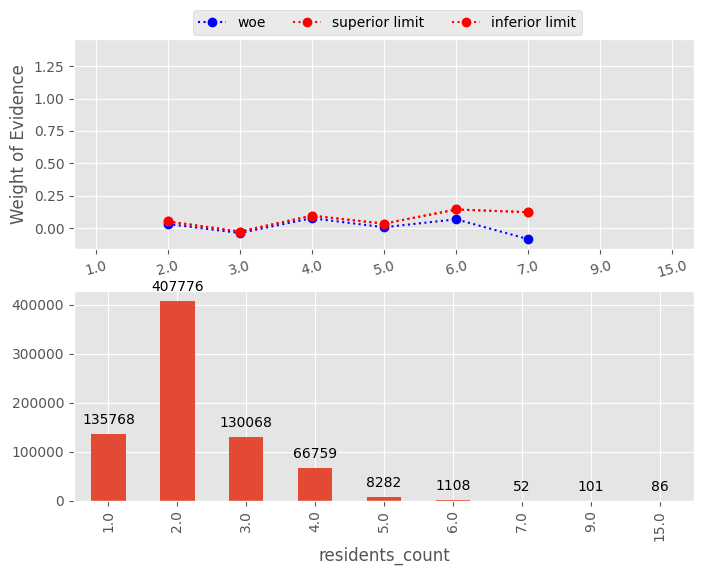

In [625]:
biv_discrete('residents_count', df_struc)

Due to small sample sizing, we are grouping all categories from 6 and beyond into one single category, this way we can address the structural zero and small sample sizes.

,qt_not_default,qt_default,default,residents_count,cont,ep,default_sup,default_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
residents_count,,,,,,,,,,,,,,
1.0,124842,10926,0.080476,1.0,135768,0.000738,0.081923,0.081923,-2.435904,-2.416508,-2.416508,0.031284,0.050680,0.050680
2.0,377007,30769,0.075456,2.0,407776,0.000414,0.076266,0.076266,-2.505756,-2.494192,-2.494192,-0.038568,-0.027004,-0.027004
3.0,119168,10900,0.083802,3.0,130068,0.000768,0.085308,0.085308,-2.391771,-2.372317,-2.372317,0.075417,0.094871,0.094871
4.0,61511,5248,0.078611,4.0,66759,0.001042,0.080653,0.080653,-2.461369,-2.433512,-2.433512,0.005819,0.033676,0.033676
5.0,7593,689,0.083192,5.0,8282,0.003035,0.089141,0.089141,-2.399741,-2.324166,-2.324166,0.067447,0.143022,0.143022
6.0,1028,80,0.072202,6.0,1108,0.007776,0.087459,0.087459,-2.553344,-2.345067,-2.345067,-0.086156,0.122121,0.122121
>6,208,31,0.129707,>6,239,0.021733,0.172520,0.172520,-1.903551,-1.567869,-1.567869,0.563637,0.899319,0.899319


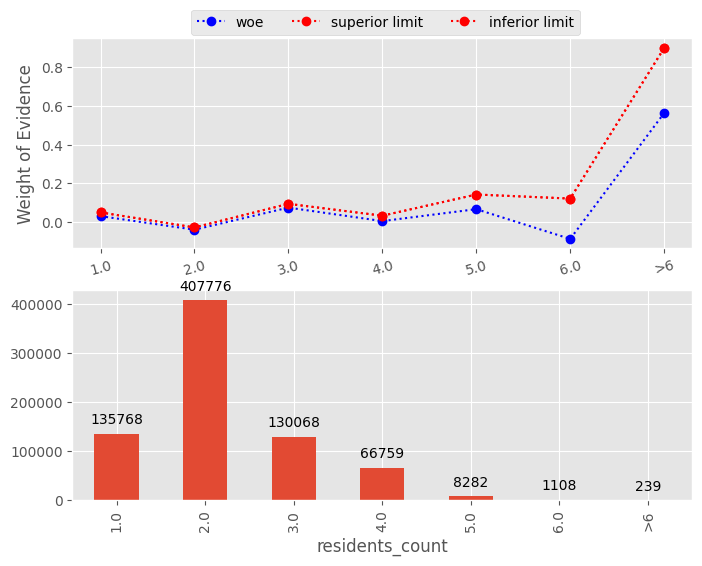

In [627]:
df_struc['residents_count'] = df_struc['residents_count'].astype(float)
df_struc['residents_count'] = df_struc['residents_count'].apply(lambda x: x if x <= 6 else '>6')
df_struc['residents_count'] = df_struc['residents_count'].astype(str)
biv_discrete('residents_count', df_struc)

#### Defining the continuous function 

In [650]:
def biv_continuous(var, ncat, df):
    df['not_default'] = 1 - df.default
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    
    # Explicitly set observed=False to silence the warning
    g = df.groupby(cat_srs, observed=False)

    biv = pd.DataFrame({'qt_not_default': g['not_default'].sum(),
                        'qt_default': g['default'].sum(),
                        'default': g['default'].mean(), 
                        var: g[var].mean(), 
                        'cont': g[var].count()})
    
    biv['ep'] = (biv.default * (1 - biv.default) / biv.cont) ** .5
    biv['default_sup'] = biv.default + t.ppf([0.975], biv.cont - 1) * biv.ep
    biv['default_inf'] = biv.default - t.ppf([0.025], biv.cont - 1) * biv.ep
    
    biv['logit'] = np.log(biv.default / (1 - biv.default))
    biv['logit_sup'] = np.log(biv.default_sup / (1 - biv.default_sup))
    biv['logit_inf'] = np.log(biv.default_inf / (1 - biv.default_inf))

    general_default_rate = df.default.mean()
    general_woe = np.log(df.default.mean() / (1 - df.default.mean()))

    biv['woe'] = biv.logit - general_woe
    biv['woe_sup'] = biv.logit_sup - general_woe
    biv['woe_inf'] = biv.logit_inf - general_woe

    fig, ax = plt.subplots(2, 1, figsize=(8, 6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='superior limit')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='inferior limit')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    
    return None


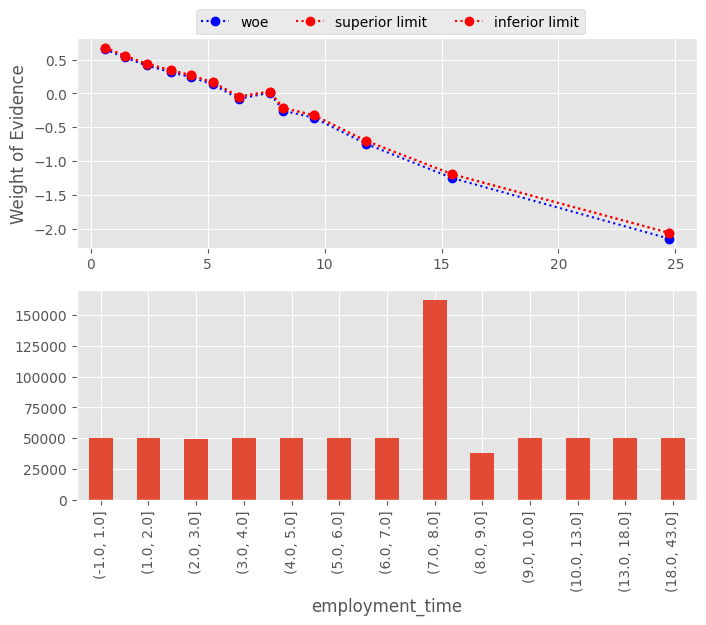

In [668]:
biv_continuous('employment_time', 15, df_struc)

Dealing with negative values

In [659]:
df_struc.loc[df_struc['employment_time']<0,'employment_time'] = -1

We have successfully treated all structural zeros from our dataset. Although there are more categories that could be grouped together, the variables under which they are present are not significant enough for our modelling task.

---

## 3. Treating Outliers

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

## Criar um pipeline utilizando o sklearn pipeline 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

### Treinar um modelo de regressão logistica com o resultado

### Salvar o pickle file do modelo treinado

In [494]:
import pickle

nome_arquivo = 'model_final.pkl'
pickle.dump(model, open(nome_arquivo, 'wb'))

NameError: name 'model' is not defined

# Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [ ]:
import pandas as pd

df = pd.read_feather('credit_scoring.ftr')
df.head()

In [ ]:
from pycaret.classification import *
models()

In [ ]:
xxx = create_model('xxx')

### Salvar o arquivo do modelo treinado

# Projeto Final

1. Subir no GITHUB todos os jupyter notebooks/códigos que você desenvolveu nesse ultimo módulo
1. Gerar um arquivo python (.py) com todas as funções necessárias para rodar no streamlit a escoragem do arquivo de treino
    - Criar um .py
    - Criar um carregador de csv no streamlit 
    - Subir um csv no streamlit 
    - Criar um pipeline de pré processamento dos dados
    - Utilizar o modelo treinado para escorar a base 
        - nome_arquivo = 'model_final.pkl'
1. Gravar um vídeo da tela do streamlit em funcionamento (usando o próprio streamlit (temos aula disso) ou qlqr outra forma de gravação).
1. Subir no Github o vídeo de funcionamento da ferramenta como README.md.
1. Subir no Github os códigos desenvolvidos. 
1. Enviar links do github para o tutor corrigir.